# JLS: Preemptive notes from student <a name="PreemptiveNotes"></a>


## Initials (JLS) signify unique content

This notebook contains a lot of supplied notes and comments. I've tried to preface
many areas that I've created with JLS. This is a pretty big notebook
so hopefully that helps. Not all of my sections contain this annotation.


## Python Environment

I downloaded this notebook from udacity, but I am using my own development environment.
- The environment for this notebook is **Python 3.10.4**
- For module versions see 
[JLS: Python Development Environment](#DevEnv) at the end of this notebook.
- See also: [requirements.txt](requirements.txt)

---

# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
#must remember to run before later free_life() !

# import libraries here; add more as necessary
## general python
from collections import Counter
from typing import List
import random
from datetime import datetime
import re
import time

## basic data science
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

## sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

#JLS
import compile_data_dictionary as cdd
nb_start = time.time()

# magic word for producing visualizations in notebook
%matplotlib inline

#JLS: I'm choosing to use an updated environment, rending the below statement obsolete
# '''
# Import note: The classroom currently uses sklearn version 0.19.
# If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
# instead of sklearn.impute as in newer versions of sklearn.
# '''

random.seed(444)

#JLS Custom typing
DataFrame = type(pd.DataFrame())
Series = type(pd.Series(dtype="object"))

# for helping select a maplotlib color style
# matplotlib.style.available
# matplotlib.style.use('default')
matplotlib.style.use('tableau-colorblind10')


### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core user base. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv("data/Udacity_AZDIAS_Subset.csv", sep=";", dtype="str")

# Load in the feature summary file.
# feat_info = pd.read_csv("data/AZDIAS_Feature_Summary.csv", sep=";", dtype="str")
# jls note: I've worked with the feature info data in a different way. See Preprocessing.

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

def quick_look(df:pd.DataFrame, name:str = "unlabeled"):
    display(f"Quick look at {name} dataframe:")
    display(f"Shape: {df.shape}")
    display(df.head())
    display(df.info())
    display(df.describe())

In [4]:
quick_look(azdias, "azdias")

'Quick look at azdias dataframe:'

'Shape: (891221, 85)'

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5,1,5,2,5,4,5,...,2,3,2,1,1,5,4,3,5,4
2,-1,3,2,3,1,4,1,2,3,5,...,3,3,1,0,1,4,4,3,5,2
3,2,4,2,2,4,2,5,2,1,2,...,2,2,2,0,1,3,4,2,3,3
4,-1,3,1,5,4,3,4,1,3,2,...,2,4,2,1,2,3,3,4,6,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   AGER_TYP               891221 non-null  object
 1   ALTERSKATEGORIE_GROB   891221 non-null  object
 2   ANREDE_KZ              891221 non-null  object
 3   CJT_GESAMTTYP          886367 non-null  object
 4   FINANZ_MINIMALIST      891221 non-null  object
 5   FINANZ_SPARER          891221 non-null  object
 6   FINANZ_VORSORGER       891221 non-null  object
 7   FINANZ_ANLEGER         891221 non-null  object
 8   FINANZ_UNAUFFAELLIGER  891221 non-null  object
 9   FINANZ_HAUSBAUER       891221 non-null  object
 10  FINANZTYP              891221 non-null  object
 11  GEBURTSJAHR            891221 non-null  object
 12  GFK_URLAUBERTYP        886367 non-null  object
 13  GREEN_AVANTGARDE       891221 non-null  object
 14  HEALTH_TYP             891221 non-null  object
 15  

None

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221,891221,891221,886367,891221,891221,891221,891221,891221,891221,...,774706,774706,774706,774706,774706,774706,774706,794005,794005,794005
unique,5,5,2,6,5,5,5,5,5,5,...,5,5,4,3,5,5,5,6,10,6
top,-1,3,2,4,3,1,5,5,1,3,...,2,3,2,0,1,3,3,4,5,3
freq,677503,358533,465305,210963,256276,250213,242262,234508,220597,235184,...,270590,307283,252994,356389,499550,309146,288383,311339,148096,274008


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

##### JLS - Compiling the Data Dictionary
I got irritated with looking at only missing values. I also wanted to try to understand unexpected values.

I probably went overboard and spent way too much time on this but...

Behold! `compile_data_dictionary.py`! It compiles all the info in `data/AZDIAS_Feature_Summary.csv`
and `data/Data_Dictionary.md`. 
(If you look at the code it's mainly a ton of regex and data structure arrangements)

Now we can look at everything we expect to see in a feature using the DataCodex class from my little module.

In [5]:
# JLS - use my new module
codex = cdd.DataCodex(
    data_dict_file="data/Data_Dictionary.md",
    feat_summary_file="data/AZDIAS_Feature_Summary.csv",
)

codex?

Type:        DataCodex
String form: <compile_data_dictionary.DataCodex object at 0x0000014B26080160>
File:        d:\dev\repos\wgu\c753 - machine learning\wgu-machinelearning-c753-p2_identifycustomersegments\compile_data_dictionary.py
Docstring:  
Array with associated photographic information.

Parameters
----------
    data_dict_file : relative file path to Data_Dictionary.md
    feat_summary_file : relative file path to AZDIAS_Feature_Summary.csv

Attributes
----------
    all_df {DataFrame} : a dataframe representing both the data
        dictionary and feature summary information for each feature
    feature_names {List[str]} : a list of feature names from `all_df`

Methods
-------
    #### get information about a feature as a data structure
    - get_feature_as_s(self, feature_name) -> Series | None
    - get_feature_as_df(self, feature_name) -> DataFrame | None
    - get_feature_as_dict(self, feature_name) -> Dict | None

    ### print or display (in a notebook) information abou

In [6]:
# demo
# target_feature_name = random.choice(codex.feature_names)
target_feature_name = "ALTERSKATEGORIE_GROB"
codex.display_feature(target_feature_name)

# print(codex.feature_names)

,value
attribute,
feature_name,ALTERSKATEGORIE_GROB
section_no,1.2.
definition,Estimated age based on given name analysis
allowed_values,"{4, 3, 2, 1}"
dim_translation,None
information_level,person
type,ordinal
missing_or_unknown,"[-1, 0, 9]"


,description
code,
-1,unknown (missing)
0,unknown (cannot be determined)
1,< 30 years old
2,30 - 45 years old
3,46 - 60 years old
4,> 60 years old
9,uniformly distributed


##### JLS - Looking at features that have less definition 
I want review features that don't have clear constraints. By that, I mean
features where codes don't exist for `allowed_values` or `missing_or_unknown`.
These will likely be freeform fields without set boundaries.

Right now I won't do too much with the, but I do want a quick count and summary.


In [7]:
under_defined_df = codex.all_df.loc[(codex.all_df["allowed_values"].isnull()) | (codex.all_df["missing_or_unknown"].isnull()),["allowed_values","missing_or_unknown"]]
display(under_defined_df)
len(under_defined_df)

,allowed_values,missing_or_unknown
feature_name,,
GFK_URLAUBERTYP,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",None
GREEN_AVANTGARDE,"[0, 1]",None
ANZ_PERSONEN,None,None
ANZ_TITEL,None,None
ANZ_HH_TITEL,None,None
KONSUMNAEHE,"[1, 2, 3, 4, 5, 6, 7]",None
GEBAEUDETYP_RASTER,"[1, 2, 3, 4, 5]",None
MOBI_REGIO,"[1, 2, 3, 4, 5, 6]",None
ONLINE_AFFINITAET,"[0, 1, 2, 3, 4, 5]",None


10

##### JLS - Review data quality

I want to understand, per feature 
- `actual_missing`: how much data doesn't have a value (was never entered, instead of encoded as missing)
- `nan_codes`: how much data has a "missing" code
- `valid_values`: how much data conforms to known valid codes
- `other_values`: everything else
  - in some cases this might be invalid data like human error
  - in some cases this might be valid but unquantified data (e.g. not every year has been individually validated)

Let's write a function to comprehensively check each feature when it's presented as a Series. We can apply that over 
our main dataframe to get a full picture.

In [8]:
def value_validity_sort(feature_data_s: Series, for_apply = True) -> Series:
    """return a dataframe for the feature with aggregated sums about the data quality
    - actual_missing = blanks
    - nan_codes = values that have an entry in missing_or_unknown
    - valid_values = values that have an entry in allowed_values 
       and are not in missing_or_unknown (if there are no allowed values, all values are allowed)
    - other_values = all other values
    """
    # oof. so somewhere along the line I edited my original codex, and so this function 
    # doesn't work with the later customer data. Lets ensure it's clean here.
    codex = cdd.DataCodex(
        data_dict_file="data/Data_Dictionary.md",
        feat_summary_file="data/AZDIAS_Feature_Summary.csv",
    )

    feature_name = feature_data_s.name
    if codex.is_feature_in_data(feature_name) == False:
        print(f"Warning! feature_name {feature_name} does not appear in the" 
        + "data_dictionary! Result for this feature will be np.nan")
        return np.nan   
    feature_meta_s = codex.get_feature_as_s(feature_name)
    # feature_data_s = azdias.loc[:,feature_name]  

    value_counts = feature_data_s.value_counts()
    value_list = value_counts.index.to_series()

    # ## Count ACTUAL MISSING values
    # represent as a pd.Series for consistency in output
    natural_missing_count = pd.Series(data=[len(feature_data_s) - sum(value_counts)],name=feature_name, dtype="int64")

    #Count NAN CODES
    missing_or_unknown = feature_meta_s.loc["missing_or_unknown"]
    if missing_or_unknown is None:
        nan_code_counts = pd.Series(dtype="int64")
    else:
        nan_code_counts = value_counts.loc[value_list.isin(missing_or_unknown)]
        #dropping nan codes from value_counts prevents counting them in "other_values"
        value_counts.drop(value_list.loc[value_list.isin(missing_or_unknown)], inplace=True)
        value_list = value_list.loc[~value_list.isin(missing_or_unknown)]

    #Count VALID and INVALID
    allowed_values = feature_meta_s.loc["allowed_values"]
    if allowed_values is None:
        #if there isn't anything to compare against, assume every value is valid
        valid_value_counts = value_counts
        invalid_value_counts = pd.Series(dtype="int64")
    else:
        valid_value_counts = value_counts.loc[value_list.isin(allowed_values)]
        invalid_value_counts = value_counts.loc[~value_list.isin(allowed_values)]

    counts = [natural_missing_count, nan_code_counts, valid_value_counts, invalid_value_counts]
    names = ["actual_missing", "nan_codes", "valid_values", "other_values"]
    sums = []

    for i in range(len(counts)):
        sums.append(sum(counts[i]))
        # print(sums)

    sums_s = pd.Series(sums, index=names, name="count", dtype="int64")
    sums_s =  pd.concat([sums_s, pd.Series(sums_s.agg("sum"), index=["sum"])])

    if for_apply:
        return sums_s
        
    # mostly for troubleshooting, and exploration - breaks "apply"
    # for i in range(len(counts)):
    #     print(f"{names[i]}:\n{counts[i]}\n")
    #
    return pd.DataFrame(data=[sums_s]).T

In [9]:
# function demo
# feature_name = random.choice(codex.feature_names)
# feature_name = "ANZ_HH_TITEL"
feature_name = "ALTERSKATEGORIE_GROB"
print(f"Feature Sample: {feature_name}")
value_validity_sort(azdias.loc[:,feature_name], for_apply=False)

Feature Sample: ALTERSKATEGORIE_GROB


,0
actual_missing,0
nan_codes,2881
valid_values,888340
other_values,0
sum,891221


##### JLS - Check the quality of the dataframe
Great! Let's check out the quality of our main dataframe. And while we're at it lets make it 
convenient to do this again in the future for any dataframe of features that's sliced from azdias

In [10]:
#I want to see everything, and notebooks love to cut out the middle.
def review_quality(azdias_derived_df = azdias, per_display = 25):
    """check the quality of the azdias dataframe or a set of it's features"""
    quality_df = azdias_derived_df.apply(value_validity_sort).T
    for i in range(len(quality_df)):
        if i % per_display == 0:
            display(quality_df[i:i+per_display-1])

review_quality()

,actual_missing,nan_codes,valid_values,other_values,sum
AGER_TYP,0,685843,205378,0,891221
ALTERSKATEGORIE_GROB,0,2881,888340,0,891221
ANREDE_KZ,0,0,891221,0,891221
CJT_GESAMTTYP,4854,0,886367,0,891221
FINANZ_MINIMALIST,0,0,891221,0,891221
FINANZ_SPARER,0,0,891221,0,891221
FINANZ_VORSORGER,0,0,891221,0,891221
FINANZ_ANLEGER,0,0,891221,0,891221
FINANZ_UNAUFFAELLIGER,0,0,891221,0,891221
FINANZ_HAUSBAUER,0,0,891221,0,891221


,actual_missing,nan_codes,valid_values,other_values,sum
SEMIO_FAM,0,0,891221,0,891221
SEMIO_REL,0,0,891221,0,891221
SEMIO_MAT,0,0,891221,0,891221
SEMIO_VERT,0,0,891221,0,891221
SEMIO_LUST,0,0,891221,0,891221
SEMIO_ERL,0,0,891221,0,891221
SEMIO_KULT,0,0,891221,0,891221
SEMIO_RAT,0,0,891221,0,891221
SEMIO_KRIT,0,0,891221,0,891221
SEMIO_DOM,0,0,891221,0,891221


,actual_missing,nan_codes,valid_values,other_values,sum
ANZ_HAUSHALTE_AKTIV,93148,6463,0,791610,891221
ANZ_HH_TITEL,97008,0,794213,0,891221
GEBAEUDETYP,93148,0,798073,0,891221
KONSUMNAEHE,73969,0,817252,0,891221
MIN_GEBAEUDEJAHR,93148,0,0,798073,891221
OST_WEST_KZ,93148,0,798073,0,891221
WOHNLAGE,93148,0,798073,0,891221
CAMEO_DEUG_2015,98979,373,791869,0,891221
CAMEO_DEU_2015,98979,373,791869,0,891221
CAMEO_INTL_2015,98979,373,791869,0,891221


,actual_missing,nan_codes,valid_values,other_values,sum
PLZ8_ANTG1,116515,0,774706,0,891221
PLZ8_ANTG2,116515,0,774706,0,891221
PLZ8_ANTG3,116515,0,774706,0,891221
PLZ8_ANTG4,116515,0,774706,0,891221
PLZ8_BAUMAX,116515,0,774706,0,891221
PLZ8_HHZ,116515,0,774706,0,891221
PLZ8_GBZ,116515,0,774706,0,891221
ARBEIT,97216,159,793846,0,891221
ORTSGR_KLS9,97216,58,793947,0,891221
RELAT_AB,97216,159,793846,0,891221


##### JLS - Looking at "other" values
Other values (not known to be either nan or valid) are the biggest question about how clean the data is.
Luckily it looks like not a lot of columns have that property. What are they?

In [11]:
quality_df = azdias.apply(value_validity_sort).T
has_other_df = quality_df[quality_df["other_values"] > 0]
display(has_other_df)
has_other_list = has_other_df.index.to_list()
display(has_other_list)
for feature_name in has_other_list:
    feature_meta_s = codex.get_feature_as_df(feature_name)
    display(feature_meta_s.loc[["definition"]])
    feature_data_s = azdias.loc[:,feature_name]
    display(feature_data_s.value_counts().head())
    del feature_data_s

    

,actual_missing,nan_codes,valid_values,other_values,sum
GEBURTSJAHR,0,392318,0,498903,891221
ANZ_HAUSHALTE_AKTIV,93148,6463,0,791610,891221
MIN_GEBAEUDEJAHR,93148,0,0,798073,891221


['GEBURTSJAHR', 'ANZ_HAUSHALTE_AKTIV', 'MIN_GEBAEUDEJAHR']

,GEBURTSJAHR
definition,Year of birth


0       392318
1967     11183
1965     11090
1966     10933
1970     10883
Name: GEBURTSJAHR, dtype: int64

,ANZ_HAUSHALTE_AKTIV
definition,Number of households in the building


1    195957
2    120982
3     62575
4     43213
5     37815
Name: ANZ_HAUSHALTE_AKTIV, dtype: int64

,MIN_GEBAEUDEJAHR
definition,First year building was mentioned in the database


1992    568776
1994     78835
1993     25488
1995     25464
1996     16611
Name: MIN_GEBAEUDEJAHR, dtype: int64

##### JLS - Clean up columns with "other"
Two of these columns are years, and the other is a non-zero integer. That should be reasonable to clean up.

Years first.

This database is looking at recent years, so we'll be generous and say that anything after 1600 is valid. The current year is 2022, and I'm pretty sure all of our data was gathered before that. Since this data is proprietary and I won't get to look at any refreshed values, I'm not going to worry about being dynamic. Being loose with these dates does allow for more possible error with typos, but I think it's the fairest way to catch issues for these years without understanding more about acceptable values.

In [12]:
year_df = azdias.loc[:,["GEBURTSJAHR", "MIN_GEBAEUDEJAHR"]]

#validate year values and convert "missing" or invalid years to nan
def flag_year(year:str):
    #assumption year is a str or can be cast to one
    #if any check fails the string is not a year
    invalid_replace = np.nan
    if str(year).isdigit() is False:
        #do first to be sure str can be cast to int
        #deals with nan as well as letters
        if np.isnan(year) is False:
            print(year) #### I want to know if there are any weird entries
        return invalid_replace
    if int(year) == 0:
        #zero would be covered by <1600, but I want to print anything odd that isn't zero
        return invalid_replace 
    if (int(year) < 1600) or (int(year) > 2022):
        print(year)  #### I want to know if there are any weird entries
        return invalid_replace
    return year
print("Year values before")
review_quality(year_df)
year_df = year_df.applymap(flag_year)
print("Year values after")
review_quality(year_df)

Year values before


,actual_missing,nan_codes,valid_values,other_values,sum
GEBURTSJAHR,0,392318,0,498903,891221
MIN_GEBAEUDEJAHR,93148,0,0,798073,891221


Year values after


,actual_missing,nan_codes,valid_values,other_values,sum
GEBURTSJAHR,392318,0,0,498903,891221
MIN_GEBAEUDEJAHR,93148,0,0,798073,891221


JLS - That should do it for years! The "other_values" columns stayed exactly the same, so any data that was 
 entered, at least looks like a year. We've moved nan values into actual missing by changing them from 
 encoded values to `np.nan`.

Lets apply the change back to the main dataframe.

In [13]:
for col in year_df.columns:
    azdias.loc[:,col] = year_df.loc[:,col]
del year_df

JLS - Lets take a look at these numbers. We read them in as strings, but there are also nan values, and we're not sure what else. If we cast every value to a string (because, for example, nan is not a string), we can use str.isdigit() to make sure it's a digit. We know that 0 is our missing value range, so we'll covert every legit digit back into an int but send any 0's to nan.

In [14]:
number_s = azdias.loc[:,"ANZ_HAUSHALTE_AKTIV"]

#validate numerical values
def check_number(x):
    x_as_s = str(x)
    if x_as_s.isdigit():
        #0 is a "missing value" - replace it with nan
        if int(x_as_s) != 0:
            return x
    return np.nan

# number_s = azdias.loc[:,"ANZ_HAUSHALTE_AKTIV"]
# number_s is a series so we can't use our df oriented quality function
display(value_validity_sort(number_s).to_frame().T) 
number_s = number_s.map(check_number)
display(value_validity_sort(number_s).to_frame().T)

,actual_missing,nan_codes,valid_values,other_values,sum
0,93148,6463,0,791610,891221


,actual_missing,nan_codes,valid_values,other_values,sum
0,99611,0,0,791610,891221


JLS - Again, this looks good! The values entered all seem valid, so we'll just accept the change in our nan_codes and move on!

Let's not forget to save these changes to our main dataframe.

In [15]:
azdias.loc[:,"ANZ_HAUSHALTE_AKTIV"] = number_s
del number_s

##### JLS - Converting remaining NaN codes to np.nan values
We've dealt with all of our columns that had unknown "other" values. They still count as "other" but we've run validations on all of them.

That means that all of our data is clean! We just want to make it consistent now. Everything that was recorded as a "missing or unknown" value can all just be converted to nan values.

Let's start by looking at our data quality again, and getting a list of every feature that contains nan encoding. We won't expect to see anything that has "other" values, since we've already converted those nan_code values to actual_missing.

In [16]:
quality_df = azdias.apply(value_validity_sort).T
has_nan_df = quality_df.loc[quality_df["nan_codes"] > 0]
display(has_nan_df)
print(len(has_nan_df))
has_nan_list = has_nan_df.index.to_list()

,actual_missing,nan_codes,valid_values,other_values,sum
AGER_TYP,0,685843,205378,0,891221
ALTERSKATEGORIE_GROB,0,2881,888340,0,891221
HEALTH_TYP,0,111196,780025,0,891221
LP_LEBENSPHASE_FEIN,4854,92778,793589,0,891221
LP_LEBENSPHASE_GROB,4854,89718,796649,0,891221
LP_FAMILIE_FEIN,4854,72938,813429,0,891221
LP_FAMILIE_GROB,4854,72938,813429,0,891221
NATIONALITAET_KZ,0,108315,782906,0,891221
PRAEGENDE_JUGENDJAHRE,0,108164,783057,0,891221
SHOPPER_TYP,0,111196,780025,0,891221


23


Cool! One nice side effect of our previous cleanup is that every remaining feature containing nan_codes *also* has a well 
defined list of allowed values. That means it will be super easy to clean these up using pd.Series.map and a dictionary
that "maps" allowed values back to themselves.

That doesn't sound very useful on the surface, but the awesome thing about using a mapping dictionary is that the series 
map function will convert everything ***outside*** of that dictionary to nan values for us! We can also ask it to ignore
existing nan values for faster processing!

##### But why df.apply instead of df.applymap?
This mapping functionality with a dictionary appears to be unique to the 
[Series.map](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.map.html) function. 
[Dataframe.applymap](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.applymap.html)
doesn't accept a dictionary - it will only take a function for modifying each value in the dataframe. Besides that,
we need to use the series to grab our list of allowed values from the codex, per feature.

TLDR: We need to write a function that can be applied to the dataframe. 
Then we can map the passed feature series.

In [17]:
def missing_to_nan(feature_data_s:Series) -> Series:
    """convert all remaining "missing" encoded values in a series to actual nan values."""
    clean_codex = cdd.DataCodex(
            data_dict_file="data/Data_Dictionary.md",
            feat_summary_file="data/AZDIAS_Feature_Summary.csv",
        )
    feature_name = feature_data_s.name
    allowed_values = set(clean_codex.get_feature_as_s(feature_name).loc["allowed_values"])
    allowed_dict = dict([(k,k) for k in allowed_values])
    return feature_data_s.map(allowed_dict, na_action="ignore")

def apply_missing_to_nan(feature_name_list:List[str], inspect:int=None, cust_df=pd.DataFrame()) -> DataFrame:
    """convenience function for applying the above function to identified features.
    optionally prints before and after comparisons using the tail() method."""
    if cust_df.empty:
        nan_encoded_df = azdias.loc[:,feature_names]
    else:
        nan_encoded_df = cust_df.loc[:,feature_names]      
    if inspect:
        display(nan_encoded_df.apply(value_validity_sort).T.tail(inspect))
    nan_encoded_df = nan_encoded_df.apply(missing_to_nan)
    if inspect:
        display(nan_encoded_df.apply(value_validity_sort).T.tail(inspect))
    return nan_encoded_df

I want to do a quick "litmus test" before I run this on the big list.
I've randomly chosen two of the features from our list to give it a try.

In [18]:
feature_names = ["AGER_TYP", "ALTER_HH"]
apply_missing_to_nan(feature_names, inspect=2);

,actual_missing,nan_codes,valid_values,other_values,sum
AGER_TYP,0,685843,205378,0,891221
ALTER_HH,73499,236768,580954,0,891221


,actual_missing,nan_codes,valid_values,other_values,sum
AGER_TYP,685843,0,205378,0,891221
ALTER_HH,310267,0,580954,0,891221


Looks great! Let's apply this to the full list of nan_encoded features and save those changes to the main dataframe. 
    I'll spotcheck the last 10 rows of the feature list as it had a good variety of nan_code counts.

In [19]:
feature_names = has_nan_list
azdias.loc[:,feature_names]=apply_missing_to_nan(feature_names, inspect=10);

,actual_missing,nan_codes,valid_values,other_values,sum
W_KEIT_KIND_HH,107602,40386,743233,0,891221
CAMEO_DEUG_2015,98979,373,791869,0,891221
CAMEO_DEU_2015,98979,373,791869,0,891221
CAMEO_INTL_2015,98979,373,791869,0,891221
KBA05_BAUMAX,133324,343200,414697,0,891221
KKK,121196,36868,733157,0,891221
REGIOTYP,121196,36868,733157,0,891221
ARBEIT,97216,159,793846,0,891221
ORTSGR_KLS9,97216,58,793947,0,891221
RELAT_AB,97216,159,793846,0,891221


,actual_missing,nan_codes,valid_values,other_values,sum
W_KEIT_KIND_HH,147988,0,743233,0,891221
CAMEO_DEUG_2015,99352,0,791869,0,891221
CAMEO_DEU_2015,99352,0,791869,0,891221
CAMEO_INTL_2015,99352,0,791869,0,891221
KBA05_BAUMAX,476524,0,414697,0,891221
KKK,158064,0,733157,0,891221
REGIOTYP,158064,0,733157,0,891221
ARBEIT,97375,0,793846,0,891221
ORTSGR_KLS9,97274,0,793947,0,891221
RELAT_AB,97375,0,793846,0,891221


Perfect!

Let's just take one last look at everything to make sure we haven't missed anything obvious.

In [20]:

review_quality(azdias)

,actual_missing,nan_codes,valid_values,other_values,sum
AGER_TYP,685843,0,205378,0,891221
ALTERSKATEGORIE_GROB,2881,0,888340,0,891221
ANREDE_KZ,0,0,891221,0,891221
CJT_GESAMTTYP,4854,0,886367,0,891221
FINANZ_MINIMALIST,0,0,891221,0,891221
FINANZ_SPARER,0,0,891221,0,891221
FINANZ_VORSORGER,0,0,891221,0,891221
FINANZ_ANLEGER,0,0,891221,0,891221
FINANZ_UNAUFFAELLIGER,0,0,891221,0,891221
FINANZ_HAUSBAUER,0,0,891221,0,891221


,actual_missing,nan_codes,valid_values,other_values,sum
SEMIO_FAM,0,0,891221,0,891221
SEMIO_REL,0,0,891221,0,891221
SEMIO_MAT,0,0,891221,0,891221
SEMIO_VERT,0,0,891221,0,891221
SEMIO_LUST,0,0,891221,0,891221
SEMIO_ERL,0,0,891221,0,891221
SEMIO_KULT,0,0,891221,0,891221
SEMIO_RAT,0,0,891221,0,891221
SEMIO_KRIT,0,0,891221,0,891221
SEMIO_DOM,0,0,891221,0,891221


,actual_missing,nan_codes,valid_values,other_values,sum
ANZ_HAUSHALTE_AKTIV,99611,0,0,791610,891221
ANZ_HH_TITEL,97008,0,794213,0,891221
GEBAEUDETYP,93148,0,798073,0,891221
KONSUMNAEHE,73969,0,817252,0,891221
MIN_GEBAEUDEJAHR,93148,0,0,798073,891221
OST_WEST_KZ,93148,0,798073,0,891221
WOHNLAGE,93148,0,798073,0,891221
CAMEO_DEUG_2015,99352,0,791869,0,891221
CAMEO_DEU_2015,99352,0,791869,0,891221
CAMEO_INTL_2015,99352,0,791869,0,891221


,actual_missing,nan_codes,valid_values,other_values,sum
PLZ8_ANTG1,116515,0,774706,0,891221
PLZ8_ANTG2,116515,0,774706,0,891221
PLZ8_ANTG3,116515,0,774706,0,891221
PLZ8_ANTG4,116515,0,774706,0,891221
PLZ8_BAUMAX,116515,0,774706,0,891221
PLZ8_HHZ,116515,0,774706,0,891221
PLZ8_GBZ,116515,0,774706,0,891221
ARBEIT,97375,0,793846,0,891221
ORTSGR_KLS9,97274,0,793947,0,891221
RELAT_AB,97375,0,793846,0,891221


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [21]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

Starting by looking for things that aren't numbers, so so I know where they live.

In [22]:
def find_non_digit_series(allowed_set:set):
    def get_non_digits(x):
        return str(x).isdigit() == False
    # [get_non_digits(x) for x in allowed_set if allowed_set]
    if allowed_set:
        if len(allowed_set) > 0:
            return(sum([get_non_digits(x) for x in allowed_set]))
        return None


digit_check_s = codex.all_df.allowed_values.apply(find_non_digit_series)
codex.all_df.allowed_values.loc[(digit_check_s > 0)]

feature_name
OST_WEST_KZ                                                  {O, W}
CAMEO_DEU_2015    {9E, 1E, 7D, 8D, 1D, 5C, 2B, 3A, 4E, 6D, 6E, 3...
Name: allowed_values, dtype: object

##### JLS - Maybe not built in histograms... I'll make it a DYI

I've read in the entire database ***as a string*** to help keep me realistic about how I treat the data. 
(You can't add or divide eye color or your first name, so storing coded integers as strings prevents silly operations.)

In those string fields, I converted a lot of empty cells to to `np.nan`. (a float value) to represent the missing data. 
So if I have both data and missing data in the same feature, the related series has both strings and floats in it.

*Histogram tools appear to hate mixing strings with floats.*

Not to worry though! A histogram is just a sorted barchart of summed values. I have summed values! Remember our 
 `value_validity_sort` function, that we used for looking at missing values originally?
 
I'll use that again and combine it with a bar chart to make my own histogram.

In [23]:
counts = azdias.apply(value_validity_sort).T
counts.head()

,actual_missing,nan_codes,valid_values,other_values,sum
AGER_TYP,685843,0,205378,0,891221
ALTERSKATEGORIE_GROB,2881,0,888340,0,891221
ANREDE_KZ,0,0,891221,0,891221
CJT_GESAMTTYP,4854,0,886367,0,891221
FINANZ_MINIMALIST,0,0,891221,0,891221


That's the data we need! But we don't really need everything... `nan_codes` is meaningless now, and it's not helpful to 
plot the total number of rows, so we won't need `sum`.

We'll sort by `actual_missing`, and we'll take a wholistic look at each feature by plotting it's "valid" and "other" 
values along with the missing. Keep in mind that in the context of this graph "valid" just means a value was in an
expected list. We've done some loose validation on "other", so we think it's good data. It's just not constrained to a specific list.

In [24]:
def graph_missing(df:DataFrame):
    counts = df.apply(value_validity_sort).drop(["nan_codes", "sum"]).T
    counts = counts.sort_values("actual_missing", ascending=False)
    counts.plot.bar(stacked=True, figsize=(20,3))

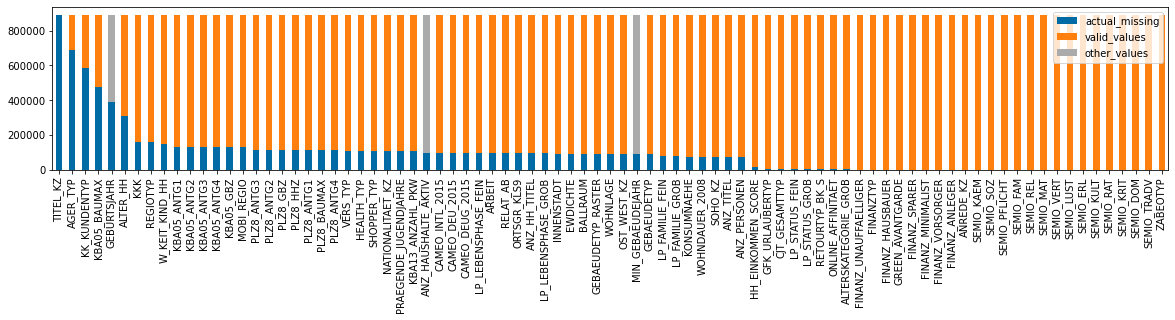

In [25]:
graph_missing(azdias)

Wow! Some of these columns have huge holes. I want a more precise look at our top 10 to understand exactly what percent of the data is missing. I'm going to normalize the values this time to make it easier to see that.

<AxesSubplot:>

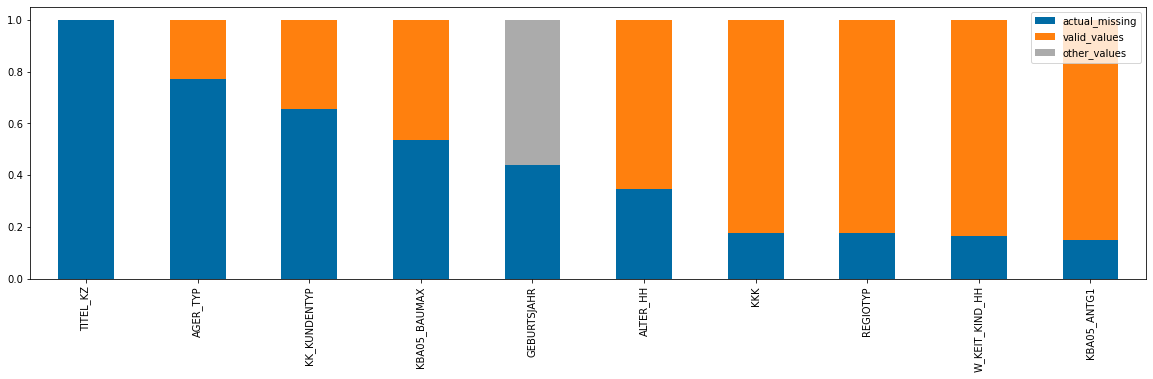

In [26]:
# sklearn.preprocessing.Normalizer
from sklearn.preprocessing import Normalizer
norm = Normalizer(norm="max")
counts = azdias.apply(value_validity_sort).drop(["nan_codes"]).T
counts = counts.sort_values("actual_missing", ascending=False)
counts_norm = pd.DataFrame(norm.fit_transform(counts), index=counts.index, columns=counts.columns)
# By normalizing with "sum" included we allow it to be the "max" value, to which the other values are scaled
# This makes all the bars stack to "1.0" which is prettier to graph and makes more sense to read when we're talking
# about a "%" of missing data.

# Keeping "sum" in the data makes for a funny graph. Get rid of it again, and then graph the top 10 missing columns
counts_norm = counts_norm.drop(["sum"], axis=1)
display(counts_norm.iloc[0:10].plot.bar(stacked=True, figsize=(20,5)))

This is where I need to make a tough call. How much missing data is "too much" missing data? 
There's a really clear drop between ALTER_HH and KKK... And alter is still missing more than a 3rd of it's values, so
I'm tempted to make the cut there. Before I do, I want to get an idea of what exactly I'm cutting. Lets look at our
data dictionary definitions.

My display function in the codex is pretty chunky in terms of space... I designed it to show me everything! We're reviewing
10 features together now, so I should slim it down.

I may want to do this again so I'll toss in a new function as well.

In [27]:
def display_definition_and_allowed_codes(feature_name, len_limit = None) -> None:
    """display the feature definition and its list of coded allowed values
    (length of code list can be limited with `len_limit` if desired)"""
    feature_s = codex.get_feature_as_s(feature_name)
    codes = feature_s.loc["codes"]
    codes = pd.DataFrame(codes, columns = ["codes"])
    codes = codes.loc[codes.index.isin(feature_s.allowed_values)]
    display(f"{feature_name}: {feature_s.loc['definition']}")
    if len_limit:
        display(codes.iloc[0:len_limit])
        if len_limit < len(codes):
            display(f"(showing the first {len_limit} of {len(codes)} codes)")
    else:
        display(codes)

missing_value_feature_names = counts_norm.iloc[0:6].index
for feature_name in missing_value_feature_names:
    display_definition_and_allowed_codes(feature_name, len_limit = 6)


'TITEL_KZ: Academic title flag'

,codes
1,Dr.
2,Dr. Dr.
3,Prof.
4,Prof. Dr.
5,other


'AGER_TYP: Best-ager typology'

,codes
1,passive elderly
2,cultural elderly
3,experience-driven elderly


'KK_KUNDENTYP: Consumer pattern over past 12 months'

,codes
1,regular customer
2,active customer
3,new costumer
4,stray customer
5,inactive customer
6,passive customer


'KBA05_BAUMAX: Most common building type within the microcell'

,codes
1,mainly 1-2 family homes in the microcell
2,mainly 3-5 family homes in the microcell
3,mainly 6-10 family homes in the microcell
4,mainly 10+ family homes in the microcell
5,mainly business buildings in the microcell


'GEBURTSJAHR: Year of birth'

,codes


'ALTER_HH: Birthdate of head of household'

,codes
1,1895-01-01 to 1899-12-31
2,1900-01-01 to 1904-12-31
3,1905-01-01 to 1909-12-31
4,1910-01-01 to 1914-12-31
5,1915-01-01 to 1919-12-31
6,1920-01-01 to 1924-12-31


'(showing the first 6 of 21 codes)'

It's easy to see how each of these values could contribute to understanding buyer behavior, and I could see how it could be possible to use them in other projects. For example, "KK_KUNDENTYP" tracks buyer behavior and it could be interesting to use that value to train a supervised model to predict customer behavior.

That said, none of these values seem exceptionally critical so we'll cut all of them off to make sure we're working with the most complete dataset possible.

In [28]:
display(f"azdias old column length: {len(azdias.columns)}")
azdias = azdias.drop(missing_value_feature_names, axis=1)
#quick check to make sure we edited our main DF the way we intended
display(f"azdias new column length: {len(azdias.columns)}")
display(f"azdias row length {len(azdias)}")

'azdias old column length: 85'

'azdias new column length: 79'

'azdias row length 891221'

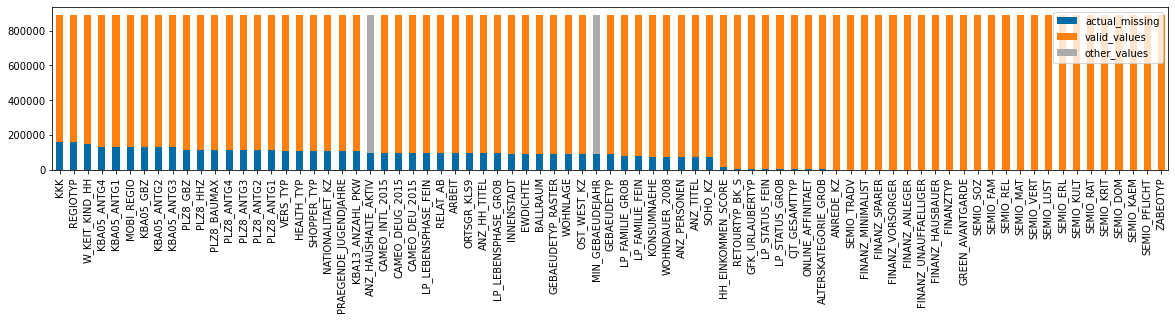

In [29]:
#Graph it again!
graph_missing(azdias)

With those few columns out of the way it's easier to think about the remaining columns with missing values.

I see that a lot of columns with similar prefixes have similar amounts of missing data. E.g. KBA05 columns are all very close to each other in the amount of data they are missing, so are the CAMEO columns and the PLZ8 columns. Similarly the FINANZ columns are all very complete, and so are the SEMIO columns.

#### Discussion 1.1.2: Assess Missing Data in Each Column

Quick summary of the observations I made above:
- After sorting columns in descending order by missing values, it's easy to see that there was a clear drop to similar 
  amounts of missing data after the first 6 columns. I took a quick look at their data dictionary definitions and then cut them. They are listed below in order of the most missing data.

- I see a pattern with the missing data: columns with similar prefixes often have similar amounts of missing data. Not all columns follow this pattern.

  |   |Removed Feature| Feature Definition                                 |
  |---|---------------|----------------------------------------------------| 
  | 1 | TITEL_KZ      | Academic title flag                                |
  | 2 | AGER_TYP      | Best-ager typology                                 |
  | 3 | KK_KUNDENTYP  | Consumer pattern over past 12 months               |
  | 4 | KBA05_BAUMAX  | Most common building type within the microcell     |
  | 5 | GEBURTSJAHR   | Year of birth                                      |
  | 6 | ALTER_HH      | Birthdate of head of household                     |

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

##### JLS Transpose and count
An easy way to see how much data is missing is to transpose the dataframe and sum the missing values.
(flipping the rows on their sides and treating them like columns lets us use the built in features more easily)
Then we can use the describe function on those sums to get a good indication of how many features are missing 
from how many rows.

In [30]:
# How much data is missing in each row of the dataset?
rows_by_missing_s = azdias.T.isna().sum()

In [31]:
rows_by_missing_s.name = "missing_features"
rows_by_missing_s.index.name = "row_index"

print("Row Quality:")
print("all rows:")
display(rows_by_missing_s.describe())
print("Rows missing >= 3 features (top 25% of missing):")
display(rows_by_missing_s.loc[rows_by_missing_s >= 3].describe())

Row Quality:
all rows:


count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
Name: missing_features, dtype: float64

Rows missing >= 3 features (top 25% of missing):


count    224348.000000
mean         22.125065
std          18.235435
min           3.000000
25%           6.000000
50%          10.000000
75%          43.000000
max          49.000000
Name: missing_features, dtype: float64

This is really encouraging! 
Somewhere between 50% and 75% of our rows don't have any missing data. 
75% of our rows are missing up to 3 rows.

In that top 25% it's still a slow progression toward the max amount of loss.

Let's look at this a little more closely and get a visualization of what's happening in that top 25.

In [32]:
display(rows_by_missing_s.head())
len(rows_by_missing_s)

row_index
0    43
1     0
2     0
3     7
4     0
Name: missing_features, dtype: int64

891221

In [33]:
def check_thresholds(threshold, df_subsection, print_progress=True):
    start = datetime.now()
    # intact_rows = df_subsection.loc[df_subsection <= threshold]
    # intact_rows.name = "intact_rows"
    incomplete_rows = df_subsection.loc[df_subsection > threshold]
    incomplete_rows.name = "incomplete_rows"
    total = len(azdias)
    incomplete = len(incomplete_rows)
    intact = total - incomplete
    feature_loss = round(threshold/len(azdias.T)*100,2)
    tradeoff_s = pd.Series(
        [intact, 
        incomplete, 
        round(intact/total*100,2), 
        round(incomplete/total*100,2), 
        feature_loss],
        index = ["intact",
        "incomplete",
        "intact_pct",
        "incomplete_pct",
        "max_feature_loss_pct"],
        name = f"{threshold}"
        )
    end = datetime.now()
    if print_progress:
        print(f"processing threshold: {threshold:<2}...")
        print((end-start))
    return tradeoff_s

In [34]:
tradeoff_df = pd.DataFrame([check_thresholds(i, rows_by_missing_s, \
    #I used to run this on every point, but it's taking well over a minute, so I'm changing the "step from 1 to 2"
    print_progress=False) for i in range(0,50,2)]);

tradeoff_df.index.name="missing value threshold"

,intact,incomplete,intact_pct,incomplete_pct,max_feature_loss_pct
missing value threshold,,,,,
4,697109.0,194112.0,78.22,21.78,5.06
6,733395.0,157826.0,82.29,17.71,7.59
8,771701.0,119520.0,86.59,13.41,10.13
10,780153.0,111068.0,87.54,12.46,12.66
12,782046.0,109175.0,87.75,12.25,15.19
14,787544.0,103677.0,88.37,11.63,17.72
16,794792.0,96429.0,89.18,10.82,20.25


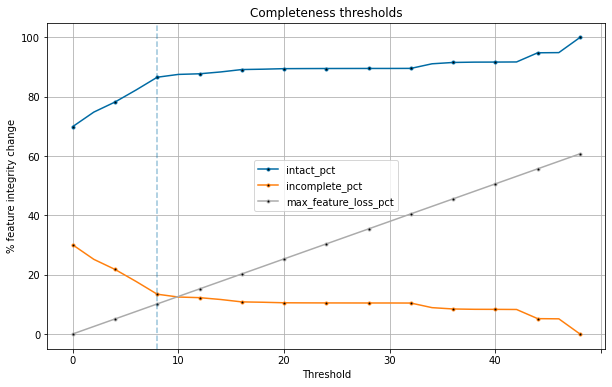

In [35]:
display(tradeoff_df.iloc[2:9])
tradeoff_df.loc[:,["intact_pct", "incomplete_pct", "max_feature_loss_pct"]].plot(
    kind='line',
    title='Completeness thresholds',
    grid=True,
    figsize=(10,6),
    markevery=2,
    markerfacecolor ="black",
    ms = 3, 
    marker='o'
    )
plt.xlabel('Threshold')
plt.ylabel("% feature integrity change");
plt.axvline(4, linestyle = "--", alpha = 0.4)

##### JLS - Threshold graph explained

##### Definitions

**Threshold**: This is the amount of data that is missing from a row. We're trying to find the best threshold at which 
 to keep data in our main dataset, or where to set it aside. Rows AT the threshold will be kept. Rows above the 
 threshold will be set aside. At threshold 50, no data is set aside. At threshold 0, 30% of data is set aside.

**"intact_pct" and "incomplete_pct"**: These are essentially the same thing, just inverted. 
 Intact is what I'm calling rows that make it into the dataset with less missing data. So seeing this number go up means
 that more rows are considered intact It's actually an indication of lower quality data being included in the main 
 data set. Incomplete rows will go into the data that we're setting aside.

**max_feature_loss_pct**: This is the *highest* percent of information that a row will be missing. Many rows will have
 much more data. The purpose of this line is to give a rudimentary idea of what a worst-case scenario looks like in
 terms of data missing from rows.

 ##### Example at threshold 5 (not the threshold I eventually I kept)

At the threshold of 5 missing features, 80.75% of rows are considered intact and will stay in the main data. 19.25% of
 rows will be set aside. To stay in our main data: a row can *at most* be missing 5 rows, and therefore could be missing 
 *up to* 6.33% of feature information. 

##### Chosen threshold: **8** missing features

Looking at both the chart and the data, I think 8 is the best threshold. We don't see a huge amount of change in the
amount of data changed at larger thresholds, but we introduce a much larger potential for maximum feature loss.

In [36]:
rows_by_missing_s.head()

row_index
0    43
1     0
2     0
3     7
4     0
Name: missing_features, dtype: int64

`rows_by_missing_s` still has a mapping of how many features each row is missing. We can use that with our chosen
threshold to provide the right True/False list to azdias to split the rows.

In [37]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
threshold = 8 #threshold is INCLUDED in the main data
azdias_main = azdias.loc[rows_by_missing_s <= threshold]
azdias_missing_data = azdias.loc[rows_by_missing_s > threshold]
del azdias #this was pretty big! Now that we've got it separated, lets delete it.
del rows_by_missing_s


In [38]:
print(len(azdias_main))
print(len(azdias_missing_data))

771701
119520


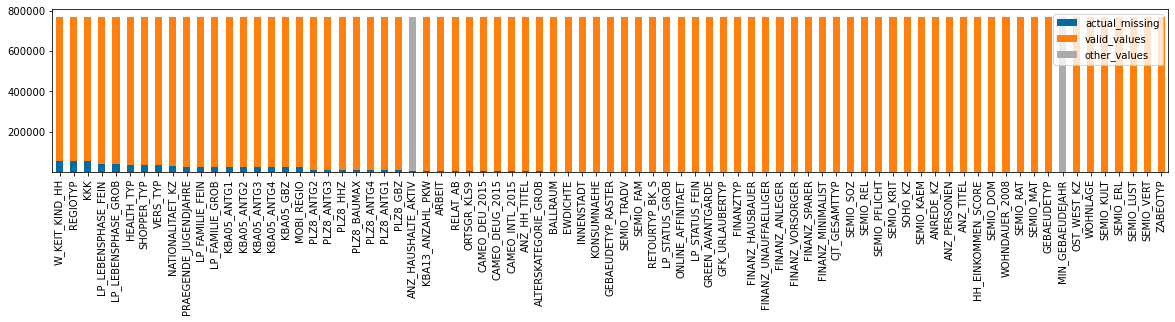

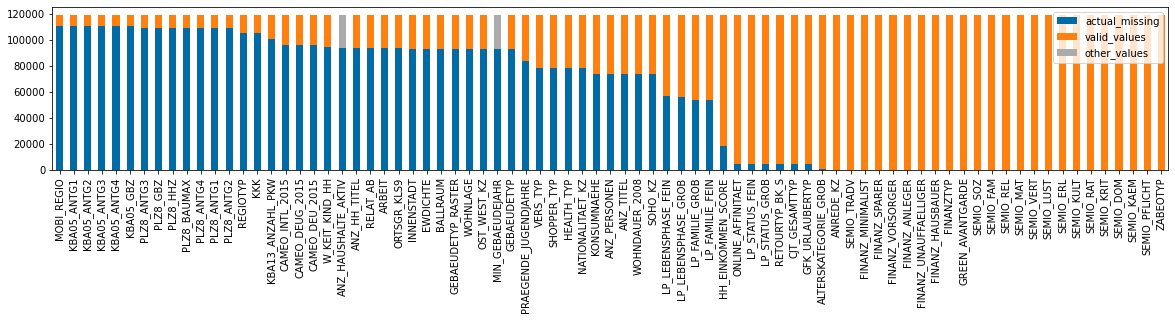

In [39]:
graph_missing(azdias_main)
graph_missing(azdias_missing_data)



count of columns eligible for comparison False    47
True     32
dtype: int64


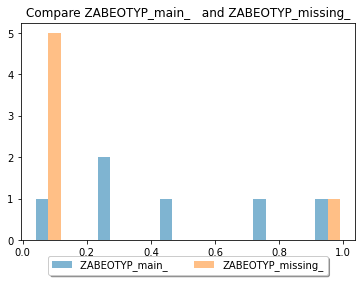

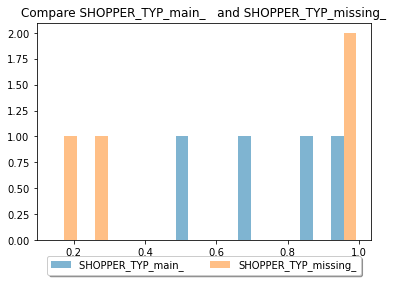

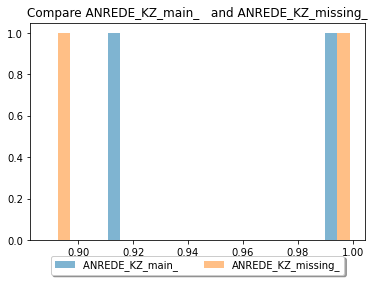

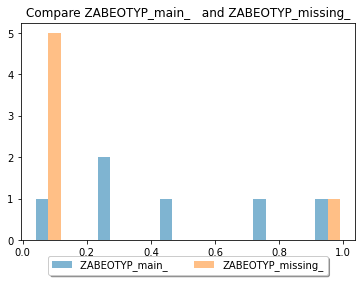

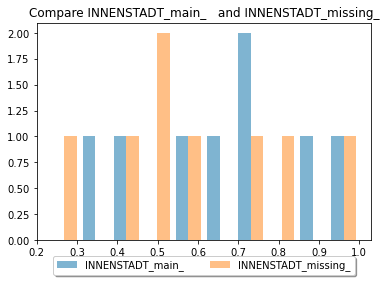

In [40]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def compare_normed_main_with_missing(feature_name):
    def count_and_norm(s: Series) -> Series:
        """return the normalized value_counts of a series"""
        vc = s.value_counts()
        norm = vc.div(vc.max())
        return norm

    # Prep corresponding columns from each df
    main_s = azdias_main.loc[:,feature_name].astype(float)
    main_s.name = f"{feature_name}_main_  "
    main_s = count_and_norm(main_s)

    missing_s = azdias_missing_data.loc[:,feature_name].astype(float)
    missing_s.name = f"{feature_name}_missing_"
    missing_s = count_and_norm(missing_s)

    # plotting two series on the same plot
    # https://stackoverflow.com/questions/6871201/plot-two-histograms-on-single-chart-with-matplotlib
    plt.title(f"Compare {main_s.name} and {missing_s.name}")
    plt.hist([main_s, missing_s], alpha=0.5, label=[main_s.name, missing_s.name])
    
    # Fancy legend outside of plot
    # https://stackoverflow.com/questions/4700614/how-to-put-the-legend-outside-the-plot
    ax = plt.subplot(111)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

    plt.show()


def random_compare(times_to_compare:int):
    # compare_main_with_missing("KKK")
    df = azdias_missing_data
    # Get, as a series of True/False, columns that have a minimum amount of data
    eligible_threshold = 0.8
    eligible_to_compare = df.isna().sum()/len(df)<(1 - eligible_threshold)
    print("count of columns eligible for comparison",eligible_to_compare.value_counts())

    for i in range(times_to_compare):
        feature_name = random.choice(eligible_to_compare.index)
        compare_normed_main_with_missing(feature_name)
        eligible_to_compare.index.drop(feature_name)

#I've set the seed in my first cell (random.seed(444)). This should select the same charts every first run.
random_compare(5) 


#### Discussion 1.1.3: Assess Missing Data in Each Row

Comparing the data in a few different columns I'd say the row quality is mixed. Some features in my "missing" dataframe
 seem to closely mimic the distribution of the same columns in my "intact" dataframe. Others seem to follow a completely
 different pattern. I'm low on resources and time for completing this project, so depending on how much I have left
 I may or may not include this in additional analysis. If I don't, I feel comfortable that while there is probably some
 interesting unique data in this set, it's not going to be massively altering to what we present to the customer if we
 don't.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [41]:
# How many features are there of each data type?

#just making sure I can get the right info...
#make sure to limit by only columns we kept
codex.all_df = codex.all_df.loc[codex.all_df.index.isin(azdias_main.columns)]
type_s = codex.all_df.type

In [42]:
type_s.value_counts()

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

##### JLS - About value types (and examples from this data)

- Ordinal data - categorical data with naturally ordered categories where it's hard to measure distance between the categories.
  - Example:  Likert scale : 1: like, 2: like somewhat, 3: Neutral, 4: Dislike somewhat, 5: Dislike
  - From this data: ordinal data represents "on this scale, how sensual is this person" or "on this scale, about how crowded is this area"
- Categorical data: data representing categories
  - Example: Favorite color? Red, Yellow, or Blue
  - In this data, largely used for questions like "What type of a family are you from" "Are you in an environmental group?" "Which nationality are you"
- Interval Data - Data points are at regularly spaced, measured, intervals
  - Example: Tempurature
  - In this data: Not shown above, so I looked in the dictionary - there was only one related feature, and we've cut it out because the column was missing too much data: "Birthdate of head of household"
- Numeric Data: Standard numbers.
  - example: Count of videos in your collection
  - In this data: Number of cars in the household, number of adults in the household

##### JLS - Generator for reviewing data chunks
I put together the below python generator and used it in combo with my codex to look through most of the data types. I rapidly edited the generator and used next() calls to print out easy to digest chunks of examples of data, and then cycle to the next chunk. Because of the way I used this feature, and out of a desire to not take up too much space with bulky data sections, I"m not going to reproduce everything I saw, but I did use it to create the above data summary.

In the current state you can also see how I used it to count up categories in categorical datasets

In [43]:
def s_display_definition_and_allowed_codes(s:Series, len_limit = None):
    display_definition_and_allowed_codes(s.name, len_limit)

def give_next_index(df, step = 1):
    """This will give me definitions and codes of the next step features in this df
    REQUIRES: that the index values of the df are feature names.
    """
    total = len(df)
    start = 0
    for i in range(total):
        end = start + step
        if end > total:
            end = total
        new_df = df.iloc[start:end]
        # display(new_df)
        # new_df = new_df.loc[:,["definition","type"]]
        new_df = new_df.loc[:,["definition","type","allowed_values"]]
        av = new_df.loc[:,"allowed_values"]
        av = av.apply(lambda x: len(list(x)))
        av.name = "count_allowed"
        new_col_count = av.map(lambda x: x - 1 if x > 2 else 0)
        new_col_count.name = "onehot_extra_cols"
        new_df = pd.concat([new_df,av,new_col_count], axis=1)
        display(new_df)
        display(sum(new_df["onehot_extra_cols"]))
        print(f"{start+1} - {end} of {total}")
        # new_df.T.apply(s_display_definition_and_allowed_codes)
        # print(":\n".join(new_df.index.to_list()))
        yield None
        start += step

codex.all_df = codex.all_df.loc[codex.all_df.index.isin(azdias_main.columns)]
categorical_gen = give_next_index(codex.all_df.loc[type_s == "categorical"], step=10)
next(categorical_gen)

,definition,type,allowed_values,count_allowed,onehot_extra_cols
feature_name,,,,,
ANREDE_KZ,Gender,categorical,"{1, 2}",2,0
CJT_GESAMTTYP,Customer-Journey-Typology: preferred informati...,categorical,"{4, 6, 2, 5, 3, 1}",6,5
FINANZTYP,Most descriptive financial type for individual,categorical,"{4, 6, 2, 5, 3, 1}",6,5
GFK_URLAUBERTYP,Vacation habits,categorical,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",12,11
GREEN_AVANTGARDE,Membership in environmental sustainability as ...,categorical,"[0, 1]",2,0
LP_FAMILIE_FEIN,"Family type, fine scale",categorical,"{6, 10, 7, 11, 9, 2, 5, 8, 4, 3, 1}",11,10
LP_FAMILIE_GROB,"Family type, rough scale",categorical,"{4, 2, 5, 3, 1}",5,4
LP_STATUS_FEIN,"Social status, fine scale",categorical,"{6, 10, 7, 9, 2, 5, 8, 4, 3, 1}",10,9
LP_STATUS_GROB,"Social status, rough scale",categorical,"{4, 2, 5, 3, 1}",5,4


50

1 - 10 of 18


##### JLS - Time to change some data types (Ordinal & Numeric to numeric)
I've been holding onto my data as string types. I did that to help me remember that I can't add (for example) eye colors
 together. After reviewing the instructions and understanding that both ordinal data and numeric data make sense as numbers
 I'm converting them to a numerical type.
 
 I'm still planning to keep categorical and mixed data as strings for now.

In [44]:
all_numeric_names = codex.all_df.loc[(type_s == "ordinal")|(type_s == "numeric")].index
azdias_main.loc[:,all_numeric_names] = azdias_main.loc[:,all_numeric_names].apply(pd.to_numeric, errors='raise', downcast=None)


In [45]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

#closer look at binary
binary_df = codex.all_df.loc[type_s == "categorical"]
binary_df = binary_df.loc[:,["definition","allowed_values"]]

#count the allowed values to filter for only binary features
av = binary_df.loc[:,"allowed_values"]
av = av.apply(lambda x: len(list(x)))
is_binary = av.map(lambda x: False if x > 2 else True)
binary_df = binary_df.loc[is_binary]

display(binary_df)

,definition,allowed_values
feature_name,,
ANREDE_KZ,Gender,"{1, 2}"
GREEN_AVANTGARDE,Membership in environmental sustainability as ...,"[0, 1]"
SOHO_KZ,Small office / home office flag,"{1, 0}"
VERS_TYP,Insurance typology,"{1, 2}"
OST_WEST_KZ,Building location via former East / West Germa...,"{O, W}"


In [46]:
codex.all_df.loc[type_s == "numeric"]

,feature_name,section_no,definition,codes,allowed_values,dim_translation,information_level,type,missing_or_unknown
feature_name,,,,,,,,,
ANZ_PERSONEN,ANZ_PERSONEN,2.2.,Number of adults in household,None,None,None,household,numeric,None
ANZ_TITEL,ANZ_TITEL,2.3.,Number of professional academic title holders ...,None,None,None,household,numeric,None
ANZ_HAUSHALTE_AKTIV,ANZ_HAUSHALTE_AKTIV,3.1.,Number of households in the building,"Series([], dtype: object)",[],None,building,numeric,[0]
ANZ_HH_TITEL,ANZ_HH_TITEL,3.2.,Number of professional academic title holders ...,None,None,None,building,numeric,None
MIN_GEBAEUDEJAHR,MIN_GEBAEUDEJAHR,3.5.,First year building was mentioned in the database,"Series([], dtype: object)",[],None,building,numeric,[0]
KBA13_ANZAHL_PKW,KBA13_ANZAHL_PKW,8.1.,Number of cars in the PLZ8 region,None,None,None,macrocell_plz8,numeric,None


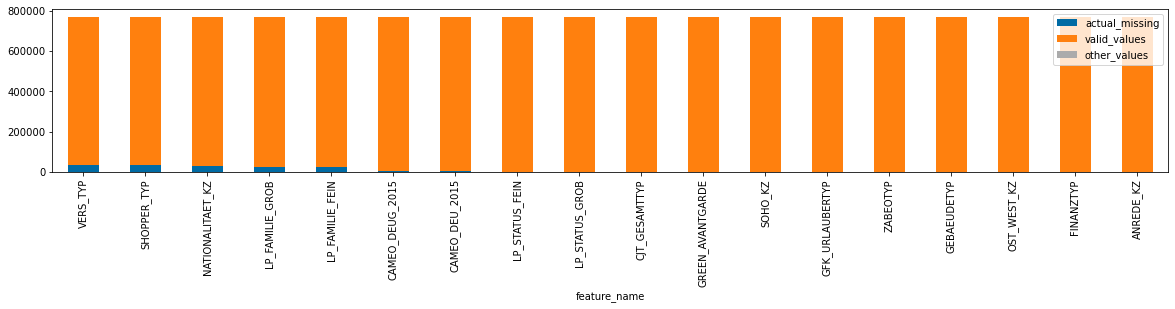

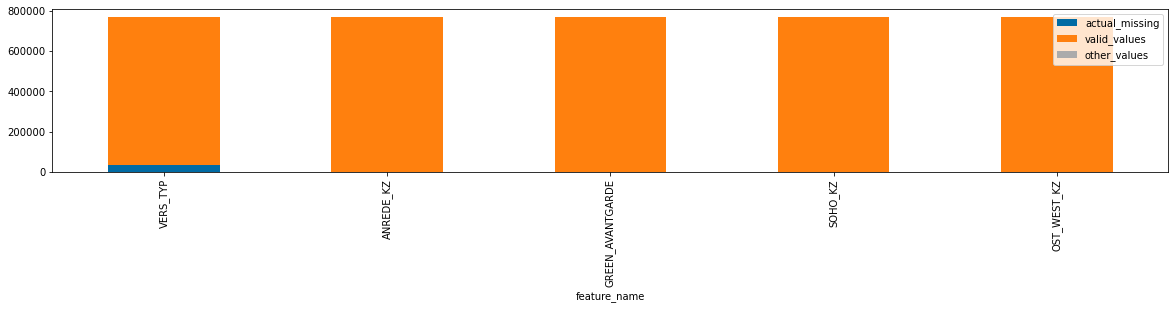

In [47]:
# Re-encode categorical variable(s) to be kept in the analysis.

#I want to get a quick view of the missing data in these columns
categorical_names = codex.all_df.loc[type_s == "categorical"].index
graph_missing(azdias_main.loc[:,categorical_names])
binary_names = binary_df.index
graph_missing(azdias_main.loc[:,binary_names])

# #TODO: YOU ARE HERE

#### Discussion 1.2.1: Re-Encode Categorical Features

I think that it isn't going to be a big deal to keep our categories and one-hot encode them. 

Because of that, I'm also not going to worry about fixing any of the binary features. I'm going to let the one-hot
encoding in sklearn fix them for me. It wouldn't be hard at all to use a map feature to fix these, but since I'm going
to the trouble of one-hot encoding it it would be redundant/wasted effort.

Before I can one-hot encode I also have to use an imputer to fix the missing nan values. So for now, I'm going to leave
these values alone and finish any other remaining preprocessing. *Then* i'll impute and one-hot encode everything at the
same time.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [48]:
# mixed_names = codex.all_df.loc[type_s == "mixed"].index

# for name in mixed_names:
#     codex.display_feature(name)

I commented out the above because it generated a lot of bloat. Most of the mixed categories have a long list of values.

I don't fully understand the data definitions in most of them either. The two clearest mixed categories are the two
required in the project instructions, so I think I'll stick with those columns and drop the rest, as it would be a lot
of time for little return value for me spend much time on them without additional context.

In [49]:
# generate a drop list and double check it against a "keep" list
features_to_drop = codex.all_df.loc[type_s == "mixed"].index.drop(["PRAEGENDE_JUGENDJAHRE","CAMEO_INTL_2015"])
print(features_to_drop)

features_to_keep = azdias_main.columns.drop(features_to_drop)
print(f"keeping {len(features_to_keep)} features of {len(azdias_main.columns)}")

Index(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE',
       'PLZ8_BAUMAX'],
      dtype='object', name='feature_name')
keeping 75 features of 79


In [50]:
azdias_main.drop(columns = features_to_drop, inplace=True)
print(len(azdias_main.columns))


75


In [51]:
# The default pandas display settings were getting in my way here, so I decided to adjust a bit.
print(pd.get_option('display.max_colwidth'))
pd.set_option('display.max_colwidth', 100)

50


In [52]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
display_definition_and_allowed_codes("PRAEGENDE_JUGENDJAHRE")

"PRAEGENDE_JUGENDJAHRE: Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)"

,codes
1,"40s - war years (Mainstream, E+W)"
2,"40s - reconstruction years (Avantgarde, E+W)"
3,"50s - economic miracle (Mainstream, E+W)"
4,"50s - milk bar / Individualisation (Avantgarde, E+W)"
5,"60s - economic miracle (Mainstream, E+W)"
6,"60s - generation 68 / student protestors (Avantgarde, W)"
7,"60s - opponents to the building of the Wall (Avantgarde, E)"
8,"70s - family orientation (Mainstream, E+W)"
9,"70s - peace movement (Avantgarde, E+W)"
10,"80s - Generation Golf (Mainstream, W)"


So we need to convert each of these numerical codes into a numerical year and a movement.

Planned breakdown with 1,2,3 as examples

> 1 : 40s - war years (Mainstream, E+W)
> 
> 2	: 40s - reconstruction years (Avantgarde, E+W)
> 
> 3	: 50s - economic miracle (Mainstream, E+W)

- PRAEGENDE_JUGENDJAHRE_YR (numerical)
  - 1 : 40
  - 2 : 40
  - 3 : 50
- PRAEGENDE_JUGENDJAHRE_M (categorical (str))
  - Encoding
    - 0 = Avantgarde
    - 1 = Mainstream
  - 1 : 1
  - 2 : 0
  - 3 : 1

##### - But how?
1. My awesome little function was able to display an easy piece of text to copy/paste (see the above "codes" table)
2. Regex can easily break this up... I could also use split functions, but I think regex will be more straightforward in this case
3. I'll convert the regex matches into a dataframe and then selectively peel the columns to build a mapping dictionary per feature
4. With a mapping feature, all I have to do is map the series! I'll map it twice and save the results to different series.
5. Finally, we drop the old feature from the dataframe and concat the two new features.

In [53]:
# 1. My awesome little function was able to display an easy piece of text to copy/paste

pj_text = """1	40s - war years (Mainstream, E+W)
2	40s - reconstruction years (Avantgarde, E+W)
3	50s - economic miracle (Mainstream, E+W)
4	50s - milk bar / Individualisation (Avantgarde, E+W)
5	60s - economic miracle (Mainstream, E+W)
6	60s - generation 68 / student protestors (Avantgarde, W)
7	60s - opponents to the building of the Wall (Avantgarde, E)
8	70s - family orientation (Mainstream, E+W)
9	70s - peace movement (Avantgarde, E+W)
10	80s - Generation Golf (Mainstream, W)
11	80s - ecological awareness (Avantgarde, W)
12	80s - FDJ / communist party youth organisation (Mainstream, E)
13	80s - Swords into ploughshares (Avantgarde, E)
14	90s - digital media kids (Mainstream, E+W)
15	90s - ecological awareness (Avantgarde, E+W)"""

# 2. Regex can easily break this up... I could also use split functions, but I think 
# regex will be more straightforward in this case

pj_pattern =re.compile(r"(\d+)\s+(\d\d).*\((\w*)")

# 3. I'll convert the regex matches into a dataframe and then selectively peel the 
# columns to build a mapping dictionary per feature
pj_df = pd.DataFrame(pj_pattern.findall(pj_text), columns=["code", "YR", "M"])
pj_df.set_index("code",inplace=True)

#Don't forget to convert words to numbers in the categorical feature values!
pj_df.loc[:,"M"] = pj_df.loc[:,"M"].map({"Avantgarde": 0, "Mainstream": 1})

#new values to dictionaries
pj_code_to_yr_dict = pj_df.loc[:,["YR"]].to_dict()["YR"]
pj_code_to_m_dict = pj_df.loc[:,["M"]].to_dict()["M"]

# Stop and check how our mapping dicts look...
print(pj_code_to_yr_dict)
print(pj_code_to_m_dict)



{'1': '40', '2': '40', '3': '50', '4': '50', '5': '60', '6': '60', '7': '60', '8': '70', '9': '70', '10': '80', '11': '80', '12': '80', '13': '80', '14': '90', '15': '90'}
{'1': 1, '2': 0, '3': 1, '4': 0, '5': 1, '6': 0, '7': 0, '8': 1, '9': 0, '10': 1, '11': 0, '12': 1, '13': 0, '14': 1, '15': 0}


In [54]:
pj_s = azdias_main.loc[:,"PRAEGENDE_JUGENDJAHRE"]
pj_s.head()

1    14
2    15
3     8
4     8
5     3
Name: PRAEGENDE_JUGENDJAHRE, dtype: object

In [55]:
# 4. With a mapping feature, all I have to do is map the series! I'll map it twice and 
# save the results to different series.

# I often try to end with "_s" or "_df" to indicate that the var is a series or a dataframe... 
# pj_m_s just seemed a bit too cryptic.
pj_m_series = pj_s.map(pj_code_to_m_dict)
pj_m_series.name = "PRAEGENDE_JUGENDJAHRE_M"
pj_yr_series = pj_s.map(pj_code_to_yr_dict)
pj_yr_series.name = "PRAEGENDE_JUGENDJAHRE_YR"

#expected transformation, given head() of PRAEGENDE_JUGENDJAHRE
"""
Code reference:
3	50s - economic miracle (Mainstream, E+W)
8	70s - family orientation (Mainstream, E+W)
14	90s - digital media kids (Mainstream, E+W)
15	90s - ecological awareness (Avantgarde, E+W)

Avantgarde = 0
Mainstream = 1

Transformed feature:
1    14 -> 90, 0
2    15 -> 90, 1
3     8 -> 70, 0
4     8 -> 70, 0
5     3 -> 50, 0
"""

new_pj = pd.concat([pj_yr_series, pj_m_series], axis=1)

display(new_pj.head())

,PRAEGENDE_JUGENDJAHRE_YR,PRAEGENDE_JUGENDJAHRE_M
1,90,1.0
2,90,0.0
3,70,1.0
4,70,1.0
5,50,1.0


In [56]:
#5. Finally, we drop the old feature from the dataframe and concat the two new features.

# Test first. Doing this all in a one liner
test = pd.concat([azdias_main, new_pj], axis=1).drop(columns="PRAEGENDE_JUGENDJAHRE")
# check output - should show that test (copy of full database) only contains two cols 
# containing old col name
display(test.loc[:,(test.columns.str.contains("PRAEGENDE_JUGENDJAHRE"))].head())

,PRAEGENDE_JUGENDJAHRE_YR,PRAEGENDE_JUGENDJAHRE_M
1,90,1.0
2,90,0.0
3,70,1.0
4,70,1.0
5,50,1.0


In [57]:
#success! persist changes and delete all these big extra DFs
azdias_main = test

In [58]:
display(azdias_main.loc[:,(azdias_main.columns.str.contains("PRAEGENDE_JUGENDJAHRE"))].head())

,PRAEGENDE_JUGENDJAHRE_YR,PRAEGENDE_JUGENDJAHRE_M
1,90,1.0
2,90,0.0
3,70,1.0
4,70,1.0
5,50,1.0


In [59]:
#I've been noticing a lot of memory usage. Maybe I'll clean up a few unused vars.
del test
del new_pj
del pj_df
del pj_s
del pj_m_series
del pj_yr_series

In [60]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
display_definition_and_allowed_codes("CAMEO_INTL_2015")


'CAMEO_INTL_2015: German CAMEO: Wealth / Life Stage Typology, mapped to international code'

,codes
11,Wealthy Households - Pre-Family Couples & Singles
12,Wealthy Households - Young Couples With Children
13,Wealthy Households - Families With School Age Children
14,Wealthy Households - Older Families & Mature Couples
15,Wealthy Households - Elders In Retirement
21,Prosperous Households - Pre-Family Couples & Singles
22,Prosperous Households - Young Couples With Children
23,Prosperous Households - Families With School Age Children
24,Prosperous Households - Older Families & Mature Couples
25,Prosperous Households - Elders In Retirement


This feature value is pretty easy, it's just that two categorical features have been smashed together. All we have to do is split the two digits.
The easy way to do that will be to treat the string as a list and map to the list position of the char we want to keep per new feature.
- The 10's place is "Wealth" the 1's place is "life status"
- The new columns will be "CAMEO_INTL_2015_WEALTH" and "CAMEO_INTL_2015_LIFESTATUS", but since all the feature names are in german, let's be consistant and go with  
  - CAMEO_INTL_2015_REICHTUM 
  - CAMEO_INTL_2015_LEBENSSTATUS


I hope google translate got me close to something appropriate :)

In [61]:
cameo_df = azdias_main.loc[:,"CAMEO_INTL_2015"]
print(cameo_df.head())
#I'm pretty sure that this is a string, but lets just be sure:
cameo_r = cameo_df.astype(str).map(lambda x: x[0])
cameo_r.name = "CAMEO_INTL_2015_REICHTUM"
cameo_l = cameo_df.astype(str).map(lambda x: x[1])
cameo_l.name = "CAMEO_INTL_2015_LEBENSSTATUS"

cameo_new = pd.concat([cameo_r, cameo_l], axis=1)
display(cameo_new)





1    51
2    24
3    12
4    43
5    54
Name: CAMEO_INTL_2015, dtype: object


,CAMEO_INTL_2015_REICHTUM,CAMEO_INTL_2015_LEBENSSTATUS
1,5,1
2,2,4
3,1,2
4,4,3
5,5,4
...,...,...
891216,4,1
891217,5,1
891218,2,4
891219,5,1


Looks great! Lets save and clean up.
I'm just going to copy and repurpose the same code I used to save on the previous feature.

In [62]:
# Test first. Doing this all in a one liner
test = pd.concat([azdias_main, cameo_new], axis=1).drop(columns="CAMEO_INTL_2015")
# check output - should show that test (copy of full database) only contains two cols 
# containing old col name
display(test.loc[:,(test.columns.str.contains("CAMEO_INTL_2015"))].head())

,CAMEO_INTL_2015_REICHTUM,CAMEO_INTL_2015_LEBENSSTATUS
1,5,1
2,2,4
3,1,2
4,4,3
5,5,4


In [63]:
azdias_main = test

In [64]:
del test
del cameo_new
del cameo_df
del cameo_l
del cameo_r

#### Discussion 1.2.2: Engineer Mixed-Type Features

I made a lot of notes throughout this section, in brief, I determined that the labor to 
payout ratio for engineering more than the required columns wasn't in my favor, especially
because I didn't feel I understood the encodings well, and didn't have the context from the
project instructions.

The two required features were a lot of fun to separate! I used regex and my data codex 
to fix the first. I fixed the last by treating the strings as lists, and grabbing them by index.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

##### JLS - Going for the imputer!
This is where I'm going to jump the gun and grab that imputer. I know it comes up later in the project, but I 
need it now so that I can one-hot encode. I just need to remember to include it in my cleaning function.

I'm checking out https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html and I think that 
 most of the defaults work well for me. Since we're representing both string and numerical data I think I'm going to go 
 with the "most_frequent" strategy. It works on both types and I think it's a better idea than filling with a constant 
 that could cause additional one-hot features.

In [65]:
imputer_frq = SimpleImputer(strategy="most_frequent")
test = imputer_frq.fit_transform(azdias_main)

Warning! feature_name PRAEGENDE_JUGENDJAHRE_YR does not appear in thedata_dictionary! Result for this feature will be np.nan
Warning! feature_name PRAEGENDE_JUGENDJAHRE_M does not appear in thedata_dictionary! Result for this feature will be np.nan
Warning! feature_name CAMEO_INTL_2015_REICHTUM does not appear in thedata_dictionary! Result for this feature will be np.nan
Warning! feature_name CAMEO_INTL_2015_LEBENSSTATUS does not appear in thedata_dictionary! Result for this feature will be np.nan


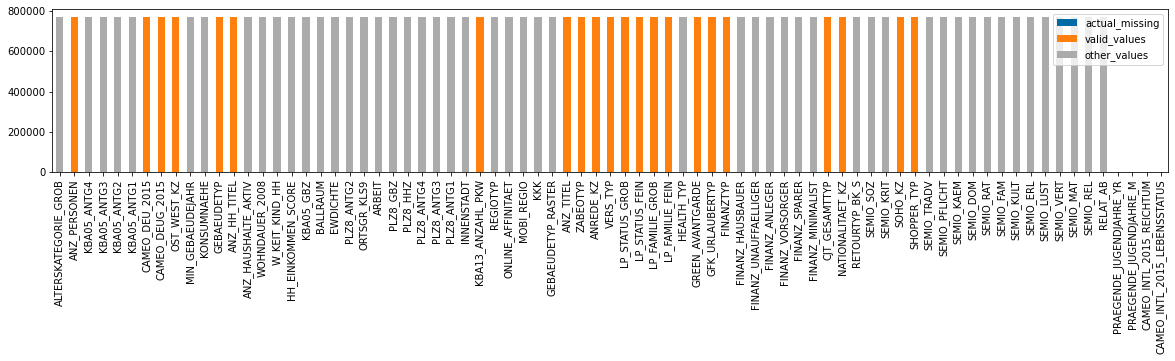

In [66]:
test = pd.DataFrame(test)
test.columns = azdias_main.columns
graph_missing(test)
# Ignore the warnings! I put those in the function that drives these graphs because 
# I wanted to know if I made typos or if anything else went sideways. I didn't consider
# that I might create new columns! It helps more than I thought now, too... now we know 
# why 4 columns are strangely blank in the graph.

This looks pretty good! Because of the way I designed my graphing/validation/codex stuff, the newly engineered features throw errors. I was trying to be careful to spot surprises when I put them together, here it just creates a little blind spot in my graph.

Other than that, we can see that there isn't any missing data. We also see a lot more columns show as "other_values" instead of "valid_values" - I'm pretty sure that's because of the conversions we made that changed strings to floats. "1.0" wouldn't show up in a list of allowed values that included "1"

I'm going to save this over the top of our main dataframe and move on to onehot encode all of the categorical features.

In [67]:
azdias_main = test

del test

In [68]:
type_s = codex.all_df.type

categorical_names = type_s.loc[type_s == "categorical"].index
#we've dropped some features that still exist in the codex. Lets get a cleaner list of categorical names.
categorical_names = azdias_main.columns[azdias_main.columns.isin(categorical_names)].to_list()
#We've also added a columns that don't appear in the codex. Let's get them added.
categorical_names.extend([
    'PRAEGENDE_JUGENDJAHRE_YR',
    'PRAEGENDE_JUGENDJAHRE_M',
    'CAMEO_INTL_2015_REICHTUM',
    'CAMEO_INTL_2015_LEBENSSTATUS'])

# azdias_main.loc[:,categorical_names]
not_categorical_names = azdias_main.columns[(~azdias_main.columns.isin(categorical_names))]

print(
    len(categorical_names), "categorical\n",
    len(not_categorical_names), "not categorical\n",
    len(azdias_main.columns), "expected total\n",
)

22 categorical
 55 not categorical
 77 expected total



In [69]:
# I've looked at the defaults and they all seem fine for my purposes.
# good example of easy use https://stackoverflow.com/questions/71555321/sklearn-preprocessing-onehotencoder-and-the-way-to-read-it
ohe = OneHotEncoder(handle_unknown="ignore")
one_hot_data = ohe.fit_transform(azdias_main.loc[:,categorical_names]);

In [70]:
transformed_categorical = pd.DataFrame(one_hot_data.toarray(), columns=ohe.get_feature_names_out())
transformed_categorical.head(3)

,ANREDE_KZ_1,ANREDE_KZ_2,CJT_GESAMTTYP_1,CJT_GESAMTTYP_2,CJT_GESAMTTYP_3,CJT_GESAMTTYP_4,CJT_GESAMTTYP_5,CJT_GESAMTTYP_6,FINANZTYP_1,FINANZTYP_2,...,CAMEO_INTL_2015_REICHTUM_3,CAMEO_INTL_2015_REICHTUM_4,CAMEO_INTL_2015_REICHTUM_5,CAMEO_INTL_2015_REICHTUM_n,CAMEO_INTL_2015_LEBENSSTATUS_1,CAMEO_INTL_2015_LEBENSSTATUS_2,CAMEO_INTL_2015_LEBENSSTATUS_3,CAMEO_INTL_2015_LEBENSSTATUS_4,CAMEO_INTL_2015_LEBENSSTATUS_5,CAMEO_INTL_2015_LEBENSSTATUS_a
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [71]:
azdias_main = azdias_main.drop(columns=categorical_names)
azdias_main = pd.concat([azdias_main, transformed_categorical], axis=1)

In [72]:
del transformed_categorical

# CHECKPOINT : Free life!
My kernel crashed a few times while concatenating these two huge datasets....
but I finally did it!

I'm building in a save point, just in case. It doesn't work for every use-case,
but maybe I can get through a little more work before I move over to a computer
with more ram...

HINT TO SELF: Close all your browsers! Free up some memory. Chrome is a RAM thief!

In [73]:
def free_life(mode):
    save_location_data = "data_process_points/azdias_preprocessed_data.csv"
    if mode == "save":
        azdias_main.to_csv(save_location_data, sep=";", index = False)
        
    if mode == "load":
        data = pd.read_csv(save_location_data, sep=";")
        codex = cdd.DataCodex(
            data_dict_file="data/Data_Dictionary.md",
            feat_summary_file="data/AZDIAS_Feature_Summary.csv",
        )
        return data, codex

# free_life("save")  

#remember! to load you have to run the import cell first
#make sure free_life("save") is commented out
#then run from this cell down
# azdias_main, codex = free_life("load")      

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

#### JLS - It's ugly, but I'll help you skip it.

I don't love the code below. It's long and redundant and very copy/paste/pray.

I finally got it to work though.

If I had more foresight I'd have designed my previous cleaning activities to be more repeatable. 
Mostly the functions I wrote were for immediate convenience and to help make sure variables got deleted.

If your using a browser, and the HTML version of this report, please feel free to skip to 
[Feature Transformation](#FeatureTransformation) with this link! It's my gift to you!

If you're in a notebook... play around with the collapsible sections or see if you can 
find an outline view, the code below is a few hundred lines.

In [74]:
def clean_data(cust_df, imputer_frq=imputer_frq, ohe=ohe):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """


    ############## CLEAN NAN

    # years
    year_df = cust_df.loc[:, ["GEBURTSJAHR", "MIN_GEBAEUDEJAHR"]]
    year_df = year_df.applymap(flag_year)
    # numerical
    number_s = cust_df.loc[:, "ANZ_HAUSHALTE_AKTIV"]
    number_s = number_s.map(check_number)

    print("Completed customer cleaning section: YEARS")


    # for anything else:
    # uses: apply_missing_to_nan(feature_name_list:List[str], inspect:int=None)
    clean_codex = cdd.DataCodex(
        data_dict_file="data/Data_Dictionary.md",
        feat_summary_file="data/AZDIAS_Feature_Summary.csv",
    ) 
    quality_df = cust_df.apply(value_validity_sort, cust_codex = clean_codex).T
    has_nan_df = quality_df.loc[quality_df["nan_codes"] > 0]
    feature_names = has_nan_df.index.to_list()
    cust_df.loc[:, feature_names] = apply_missing_to_nan(feature_names, cust_df=cust_df)

    ############ NAN DONE
    print("Completed customer cleaning section: NAN REPLACEMENT")

    ################ REMOVE COLUMNS WITH MISSING DATA

    # It seems to me like we can't just remove ANY columns from the customers data
    # Doesn't it have to be the same ones? Here's what I removed in the larger set:

    drop_features = [
        "TITEL_KZ",
        "AGER_TYP",
        "KK_KUNDENTYP",
        "KBA05_BAUMAX",
        "GEBURTSJAHR",
        "ALTER_HH",
    ]
    cust_df = cust_df.drop(drop_features, axis=1)
    print("Completed customer cleaning section: MISSING COLS")
    ############ COLUMNS DONE

    ############# REMOVE ROWS

    # How much data is missing in each row of the dataset?
    rows_by_missing_s = cust_df.T.isna().sum()
    threshold = 8 #threshold is INCLUDED in the main data
    cust_df_main = cust_df.loc[rows_by_missing_s <= threshold]
    # cust_df_missing_data = cust_df.loc[rows_by_missing_s > threshold] # save some space unless we need this...
    del cust_df #this was pretty big! Now that we've got it separated, lets delete it.
    del rows_by_missing_s
    print("Completed customer cleaning section: MISSING ROWS")
    ############ ROWS DONE

    # change data type for ordinal/numerical

    type_s = codex.all_df.loc[codex.all_df.index.isin(cust_df_main.columns)].type
    all_numeric_names = codex.all_df.loc[(type_s == "ordinal")|(type_s == "numeric")].index
    cust_df_main.loc[:,all_numeric_names] = cust_df_main.loc[:,all_numeric_names].apply(pd.to_numeric, errors='raise', downcast=None)


    # drop additional mixed features

    type_s = codex.all_df.loc[codex.all_df.index.isin(cust_df_main.columns)].type
    features_to_drop = codex.all_df.loc[type_s == "mixed"].index.drop(["PRAEGENDE_JUGENDJAHRE","CAMEO_INTL_2015"])
    # print(features_to_drop)

    features_to_keep = cust_df_main.columns.drop(features_to_drop)
    # print(f"keeping {len(features_to_keep)} features of {len(cust_df_main.columns)}")

    cust_df_main.drop(columns = features_to_drop, inplace=True)
    # print(len(cust_df_main.columns))


    # ##### engineering 1

    # 1. My awesome little function was able to display an easy piece of text to copy/paste

    pj_text = """1	40s - war years (Mainstream, E+W)
    2	40s - reconstruction years (Avantgarde, E+W)
    3	50s - economic miracle (Mainstream, E+W)
    4	50s - milk bar / Individualisation (Avantgarde, E+W)
    5	60s - economic miracle (Mainstream, E+W)
    6	60s - generation 68 / student protestors (Avantgarde, W)
    7	60s - opponents to the building of the Wall (Avantgarde, E)
    8	70s - family orientation (Mainstream, E+W)
    9	70s - peace movement (Avantgarde, E+W)
    10	80s - Generation Golf (Mainstream, W)
    11	80s - ecological awareness (Avantgarde, W)
    12	80s - FDJ / communist party youth organisation (Mainstream, E)
    13	80s - Swords into ploughshares (Avantgarde, E)
    14	90s - digital media kids (Mainstream, E+W)
    15	90s - ecological awareness (Avantgarde, E+W)"""

    # 2. Regex can easily break this up... I could also use split functions, but I think
    # regex will be more straightforward in this case

    pj_pattern =re.compile(r"(\d+)\s+(\d\d).*\((\w*)")

    # 3. I'll convert the regex matches into a dataframe and then selectively peel the
    # columns to build a mapping dictionary per feature
    pj_df = pd.DataFrame(pj_pattern.findall(pj_text), columns=["code", "YR", "M"])
    pj_df.set_index("code",inplace=True)

    #Don't forget to convert words to numbers in the categorical feature values!
    pj_df.loc[:,"M"] = pj_df.loc[:,"M"].map({"Avantgarde": 0, "Mainstream": 1})

    #new values to dictionaries
    pj_code_to_yr_dict = pj_df.loc[:,["YR"]].to_dict()["YR"]
    pj_code_to_m_dict = pj_df.loc[:,["M"]].to_dict()["M"]

    # Stop and check how our mapping dicts look...
    # print(pj_code_to_yr_dict)
    # print(pj_code_to_m_dict)

    pj_s = cust_df_main.loc[:,"PRAEGENDE_JUGENDJAHRE"]
    # pj_s.head()

    # 4. With a mapping feature, all I have to do is map the series! I'll map it twice and
    # save the results to different series.

    # I often try to end with "_s" or "_df" to indicate that the var is a series or a dataframe...
    # pj_m_s just seemed a bit too cryptic.
    pj_m_series = pj_s.map(pj_code_to_m_dict)
    pj_m_series.name = "PRAEGENDE_JUGENDJAHRE_M"
    pj_yr_series = pj_s.map(pj_code_to_yr_dict)
    pj_yr_series.name = "PRAEGENDE_JUGENDJAHRE_YR"

    #expected transformation, given head() of PRAEGENDE_JUGENDJAHRE
    """
    Code reference:
    3	50s - economic miracle (Mainstream, E+W)
    8	70s - family orientation (Mainstream, E+W)
    14	90s - digital media kids (Mainstream, E+W)
    15	90s - ecological awareness (Avantgarde, E+W)

    Avantgarde = 0
    Mainstream = 1

    Transformed feature:
    1    14 -> 90, 0
    2    15 -> 90, 1
    3     8 -> 70, 0
    4     8 -> 70, 0
    5     3 -> 50, 0
    """

    new_pj = pd.concat([pj_yr_series, pj_m_series], axis=1)

    # 5. Finally, we drop the old feature from the dataframe and concat the two new features.
    # Test first. Doing this all in a one liner

    test = pd.concat([cust_df_main, new_pj], axis=1).drop(columns="PRAEGENDE_JUGENDJAHRE")
    # check output - should show that test (copy of full database) only contains two cols
    # containing old col name
    # display(test.loc[:,(test.columns.str.contains("PRAEGENDE_JUGENDJAHRE"))].head())
    #success! persist changes and delete all these big extra DFs
    cust_df_main = test
    del test
    del new_pj
    del pj_df
    del pj_s
    del pj_m_series
    del pj_yr_series

    print("Completed customer cleaning section: PRAEGENDE_JUGENDJAHRE")

    # engineering 2

    cameo_df = cust_df_main.loc[:,"CAMEO_INTL_2015"]
    # print(cameo_df.head())
    #I'm pretty sure that this is a string, but lets just be sure:
    cameo_r = cameo_df.astype(str).map(lambda x: x[0])
    cameo_r.name = "CAMEO_INTL_2015_REICHTUM"
    cameo_l = cameo_df.astype(str).map(lambda x: x[1])
    cameo_l.name = "CAMEO_INTL_2015_LEBENSSTATUS"

    cameo_new = pd.concat([cameo_r, cameo_l], axis=1)
    # display(cameo_new)
    # Test first. Doing this all in a one liner
    test = pd.concat([cust_df_main, cameo_new], axis=1).drop(columns="CAMEO_INTL_2015")
    # check output - should show that test (copy of full database) only contains two cols
    # containing old col name
    # display(test.loc[:,(test.columns.str.contains("CAMEO_INTL_2015"))].head())
    cust_df_main = test
    del test
    del cameo_new
    del cameo_df
    del cameo_l
    del cameo_r
    print("Completed customer cleaning section: CAMEO_INTL_2015")

    # imputer

    # imputer_frq = SimpleImputer(strategy="most_frequent")
    test = imputer_frq.transform(cust_df_main)
    test = pd.DataFrame(test)
    test.columns = cust_df_main.columns

    graph_missing(test)
    cust_df_main = test

    del test
    print("Completed customer cleaning section: IMPUTING MISSING DATA")

    # onehot

    type_s = codex.all_df.type

    categorical_names = type_s.loc[type_s == "categorical"].index
    #we've dropped some features that still exist in the codex. Lets get a cleaner list of categorical names.
    categorical_names = cust_df_main.columns[cust_df_main.columns.isin(categorical_names)].to_list()
    #We've also added a columns that don't appear in the codex. Let's get them added.
    categorical_names.extend([
        'PRAEGENDE_JUGENDJAHRE_YR',
        'PRAEGENDE_JUGENDJAHRE_M',
        'CAMEO_INTL_2015_REICHTUM',
        'CAMEO_INTL_2015_LEBENSSTATUS'])

    # cust_df_main.loc[:,categorical_names]
    not_categorical_names = cust_df_main.columns[(~cust_df_main.columns.isin(categorical_names))]

    print(
        len(categorical_names), "\tcategorical\n",
        len(not_categorical_names), "\tnot categorical\n",
        len(cust_df_main.columns), "\texpected total\n",
    )

    one_hot_data = ohe.transform(cust_df_main.loc[:,categorical_names])
    transformed_categorical = pd.DataFrame(one_hot_data.toarray(), columns=ohe.get_feature_names_out())
    cust_df_main = cust_df_main.drop(columns=categorical_names)
    cust_df_main = pd.concat([cust_df_main, transformed_categorical], axis=1)
    del transformed_categorical

    print("Completed customer cleaning section: ONE HOT")


    
    # Return the cleaned dataframe.
    print("ALL CUSTOMER CLEANING FINISHED")
    return cust_df_main
    
    

## Step 2: Feature Transformation <a name="FeatureTransformation"></a>

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [75]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

# JLS - Done! We imputed this thing a a while back!

In [76]:
# Apply feature scaling to the general population demographics data.

std_scale = StandardScaler()
azdias_main = pd.DataFrame(std_scale.fit_transform(azdias_main), columns=azdias_main.columns)


In [77]:
azdias_main.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,CAMEO_INTL_2015_REICHTUM_3,CAMEO_INTL_2015_REICHTUM_4,CAMEO_INTL_2015_REICHTUM_5,CAMEO_INTL_2015_REICHTUM_n,CAMEO_INTL_2015_LEBENSSTATUS_1,CAMEO_INTL_2015_LEBENSSTATUS_2,CAMEO_INTL_2015_LEBENSSTATUS_3,CAMEO_INTL_2015_LEBENSSTATUS_4,CAMEO_INTL_2015_LEBENSSTATUS_5,CAMEO_INTL_2015_LEBENSSTATUS_a
0,-1.764603,-1.488002,1.539656,-1.043931,1.468403,0.981832,1.326992,1.007628,-1.675291,0.431973,...,-0.304116,-0.562460,1.584327,-0.065921,1.490254,-0.327383,-0.416408,-0.643886,-0.416022,-0.065921
1,0.199826,-1.488002,0.866704,-1.769993,-0.569520,0.264219,1.326992,1.007628,-0.302370,-0.082619,...,-0.304116,-0.562460,-0.631183,-0.065921,-0.671027,-0.327383,-0.416408,1.553069,-0.416022,-0.065921
2,1.182040,0.690044,-0.479200,1.134255,-0.569520,-1.171006,-0.819321,-0.314912,-0.988830,0.431973,...,-0.304116,-0.562460,-0.631183,-0.065921,-0.671027,3.054524,-0.416408,-0.643886,-0.416022,-0.065921
3,0.199826,0.690044,0.193752,0.408193,-1.248828,0.264219,-0.819321,1.007628,1.070552,0.946565,...,-0.304116,1.777904,-0.631183,-0.065921,-0.671027,-0.327383,2.401493,-0.643886,-0.416022,-0.065921
4,-1.764603,-0.035971,-1.152152,1.134255,-0.569520,-0.453393,1.326992,1.007628,-0.302370,-1.111804,...,-0.304116,-0.562460,1.584327,-0.065921,-0.671027,-0.327383,-0.416408,1.553069,-0.416022,-0.065921


### Discussion 2.1: Apply Feature Scaling

It makes a lot of sense to apply StandardScaler in this case, and so I went with the recommendation. Normalization works when when you're trying to put units with dissimilar units in context with each other. That's not what we're trying to do here - instead we need to format the data to fit a standard statistical shape to make it easier to work with.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

##### JLS Note to self:
Remember this awesome layman's breakdown of what PCA is doing:
https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues

Very very short version - the varience of the data is a measure of how different the data is from other data. 
 Variance helps us understand how our entries are different.
 Features that are pretty much the same for all entries aren't helpful because they don't tell us anything about 
 why a feature relates to other parts of the data. So as we start to clear out features,
 the super homogenous ones don't need to be in our face any more. In PCA We're looking for an n_components 
 value that helps us maximize the variance while minimizing the number of features.

But don't be fooled!

PCA doesn't select features to keep and throw away, instead it does math to combine features 
 mathematically so that the the new cryptic values tell us something useful 
 about how the data is different. It's like realizing that you have too many stakes and ropes
 on your tent and replacing a few with one rope that stretches the tent in exactly the same
 way and with the same force. That's vector math!

One more important thing about PCA is that it knows the math behind how much each "tent stake" was pulling before
we replaced a few with our new rope. That means we can know how important each rope was to the overall direction.
So even though we have a bunch of new (and cryptic unrecognizable features), we can get a component report to know
Which features are important to the ones that remain.

In [78]:
# Apply PCA to the data.


# # We have a ton of columns after one hot, so we're going to take up the instructions on 
# # the offer to "set a number of components that is at least half the number of features"
# # instead of not setting any parameters.
# n_components = ceil(len(azdias_main)/2)
# pca = PCA(n_components)
# X_pca = pca.fit_transform(azdias_main)


pca = PCA()
_ = pca.fit_transform(azdias_main)


In [79]:
# Reminder - each component is responsible for X % of variance and it won't change with number of components
# so the first component (no mater how many components), will always represent the same amount of variance 
# The first always represents the most, and the last always represents the least.
for n in range(2,5):
    print(f"component variances if n_components = {n}")
    demo_pca = PCA(n)
    _ = demo_pca.fit_transform(azdias_main.loc[0:20]) #limiting the features for this reminder_to_self demo
    explained_variance_ratio = demo_pca.explained_variance_ratio_
    print ("\t",explained_variance_ratio, "\n")


component variances if n_components = 2
	 [0.11973874 0.10769376] 

component variances if n_components = 3
	 [0.11973874 0.10769376 0.08892774] 

component variances if n_components = 4
	 [0.11973874 0.10769376 0.08892774 0.08019384] 



213


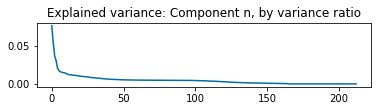

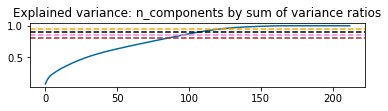

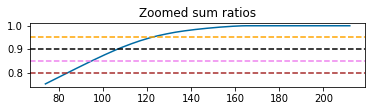

In [80]:
# Investigate the variance accounted for by each principal component.

# https://stackoverflow.com/questions/22984335/recovering-features-names-of-explained-variance-ratio-in-pca-with-sklearn
# getting feature importance


#doesn't do anything with feature importance yet.
def variance_report(pca: PCA, feature_names) -> Series:
    ev = pca.explained_variance_
    ev_ratio = pca.explained_variance_ratio_
    print(len(ev_ratio))

    x_size = pca.n_components_

    ev_ratio_sums = []
    for n in range(len(ev_ratio)):
        ev_ratio_sums.append(sum(ev_ratio[:n+1]))

    ev_ratio_sums = pd.Series(ev_ratio_sums)

    """
    reminder to self about meaning of 3 digits in subplot(211)
    See "args" in https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplot.html
    """
    ax1 = plt.subplot(311)
    ax1.plot(ev_ratio)
    ax1.title.set_text("Explained variance: Component n, by variance ratio")
    plt.show()

    ax2 = plt.subplot(312)
    ax2.plot(ev_ratio_sums)
    ax2.title.set_text("Explained variance: n_components by sum of variance ratios")
    ax2.axhline(y=0.95, linestyle="dashed", color="orange")
    ax2.axhline(y=0.90, linestyle="dashed", color="black")
    ax2.axhline(y=0.85, linestyle="dashed", color="violet")
    ax2.axhline(y=0.80, linestyle="dashed", color="brown")
    plt.show()

    ax3 = plt.subplot(313)
    ax3.plot(pd.Series(ev_ratio_sums.loc[(ev_ratio_sums > 0.75)]))
    ax3.title.set_text("Zoomed sum ratios")
    ax3.axhline(y=0.95, linestyle="dashed", color="orange")
    ax3.axhline(y=0.90, linestyle="dashed", color="black")
    ax3.axhline(y=0.85, linestyle="dashed", color="violet")
    ax3.axhline(y=0.80, linestyle="dashed", color="brown")
    plt.show()

    return pd.Series(ev_ratio), ev_ratio_sums

ev_ratio, ev_ratio_sums = variance_report(pca, azdias_main.columns)

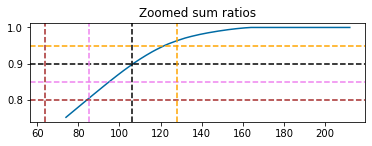

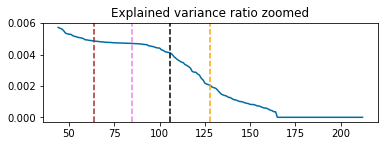

In [81]:
    def get_n_at_ratio(ratio):
        n_max = len(ev_ratio_sums)
        return round(n_max * ratio, 0)

    ax1 = plt.subplot(211)
    ax1.plot(ev_ratio_sums.loc[(ev_ratio_sums > 0.75)])
    ax1.title.set_text("Zoomed sum ratios")
    ax1.axhline(y=0.95, linestyle="dashed", color="orange")
    ax1.axhline(y=0.90, linestyle="dashed", color="black")
    ax1.axhline(y=0.85, linestyle="dashed", color="violet")
    ax1.axhline(y=0.80, linestyle="dashed", color="brown")
    ax1.axvline(x=get_n_at_ratio(0.6), linestyle="dashed", color="orange")
    ax1.axvline(x=get_n_at_ratio(0.5), linestyle="dashed", color="black")
    ax1.axvline(x=get_n_at_ratio(0.4), linestyle="dashed", color="violet")
    ax1.axvline(x=get_n_at_ratio(0.3), linestyle="dashed", color="brown")
    plt.show()
    
    ax2 = plt.subplot(212)
    ax2.plot(ev_ratio.loc[(ev_ratio_sums > 0.60)])
    ax2.title.set_text("Explained variance ratio zoomed")
    ax2.axvline(x=get_n_at_ratio(0.6), linestyle="dashed", color="orange")
    ax2.axvline(x=get_n_at_ratio(0.5), linestyle="dashed", color="black")
    ax2.axvline(x=get_n_at_ratio(0.4), linestyle="dashed", color="violet")
    ax2.axvline(x=get_n_at_ratio(0.3), linestyle="dashed", color="brown")
    plt.show()

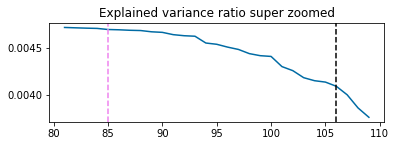

In [82]:
    ax1 = plt.subplot(212)
    ax1.plot(ev_ratio.loc[(ev_ratio.index > 80)&(ev_ratio.index < 110)])
    ax1.title.set_text("Explained variance ratio super zoomed")
    ax1.axvline(x=get_n_at_ratio(0.5), linestyle="dashed", color="black")
    ax1.axvline(x=get_n_at_ratio(0.4), linestyle="dashed", color="violet")
    plt.show()

In [83]:
pd.DataFrame([ev_ratio_sums.iloc[95:101],ev_ratio.iloc[95:101]], index=["evr_sums", "explained variance ratio"]).T


,evr_sums,explained variance ratio
95,0.849734,0.004543
96,0.854246,0.004512
97,0.858733,0.004487
98,0.863175,0.004442
99,0.867596,0.004420
100,0.872008,0.004412


In [84]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(96)
azdias_pca = pca.fit_transform(azdias_main)

### Discussion 2.2: Perform Dimensionality Reduction

By graphing the explained variance ratios, we can see that we get our fastest gains early and then diminishing returns.
 If we really wanted to limit the feature count we might pic somewhere between 10 and 50 for N, at least enough to get
 50% variance maintained.

I wanted to hit a higher amount of variance retention, so I'm living with diminishing returns and I'll slice later in
 the graph. I wanted to get the best bang for my buck, and I also wanted to at least cut off half of my features.

Because the rate of change was pretty consistent in the area that I wanted to snip, I'm going to go by a % variance
threshold, and choose 85% as the cutoff. That puts me at 96 features.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [ ]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.


def get_component(pca, index):
    # pca.components_ : ndarray of shape (n_components, n_features)
    return pd.Series(pca.components_[index], index=pca.feature_names_in_).sort_values(ascending=False)

def get_component_info(pca, index) -> DataFrame:
    c = get_component(pca, index)
    c.name = "weight"

    #get def and translation
    def_list = []
    trans_list = []
    inf_list = []
    type_list = []
    first_code_list = []
    last_code_list = []
    count = 0
    for feature_name in c.index:
        count += 1
        found = False
        if codex.is_feature_in_data(feature_name) is False:
            feature_split = feature_name.rsplit(sep="_", maxsplit=1)
            feature_name = feature_split[0]
            code = feature_split[1]
            if codex.is_feature_in_data(feature_name) is False:
                feature_split = feature_name.rsplit(sep="_", maxsplit=1)
                def_list.append("No definition found")
                trans_list.append(None)
                inf_list.append(None)
                type_list.append(None)
                first_code_list.append(None)
                last_code_list.append(None)
            else: 
                found = True
        else:
            found = True

        if found is True:
            feature_s = codex.get_feature_as_s(feature_name)
            def_list.append(feature_s.loc["definition"])
            trans_list.append(feature_s.loc["dim_translation"])
            inf_list.append(feature_s.loc["information_level"])
            type_list.append(feature_s.loc["type"])
            codes = feature_s.loc["codes"]
            try:
                # Reminder about codes structure:
                #     codes_s = pd.Series(definitions, index=symbols, dtype="object") 
                codes = codes.loc[codes.index.isin(feature_s.loc["allowed_values"])]
                first_code_list.append(f"{codes.index[0]} : {codes.iloc[0]}") 
                last_code_list.append(f"{codes.index[-1]} : {codes.iloc[-1]}") 
            except:
                first_code_list.append(None)
                last_code_list.append(None)
                
                    
            
    d = pd.Series(def_list, index=c.index)
    d.name = "definition"
    t = pd.Series(trans_list, index=c.index)
    t.name = "dim_translation"
    inf = pd.Series(inf_list, index=c.index)
    inf.name = "information_level"
    tl = pd.Series(type_list, index=c.index)
    tl.name = "type"
    fc = pd.Series(first_code_list, index=c.index)
    fc.name = "codes[0]"
    lc = pd.Series(last_code_list, index=c.index)
    lc.name = "codes[-1]"

    return pd.DataFrame([inf,c,d,t,fc,lc,tl]).T


In [ ]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
get_component_info(pca, 0)

In [ ]:


get_component_info(pca, 1)

In [ ]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

get_component_info(pca, 2)

### Discussion 2.3: Interpret Principal Components

All three of my strongest components are interesting and easy to interpret

1. Tough region and low income
   - tough neighborhoods and low wealth bring up this component, the reverse brings it down.
2. Idealism and traditional values
   - brought up by older generation, a sense of duty, strong religion, frugalness, traditional values, being inconspicuous
   - brought down by younger generations, sensuality, event-orientated, standing out
   - This stat could qualify for review in the moral/ethical area of ageism because it strongly correlates age with values.
3. Male gender, dominance, unattached to family/society
   - strongly affected by gender (up male, down female)
   - brought up by low affinities for family, society, cooperativeness
   - brought down by low affinities for events, dominance, criticality, combativeness
   - This stat could require moral/ethical review because it strongly correlates genders with personalities and traditional gender roles.
     - It would be important to know how this data was gathered and how it might have been biased.
   - This stat could be an interesting study of gender roles and self or societal perception.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [ ]:
# Over a number of different cluster counts...


    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.
    
    

This is where I'm figuring out what I'm doing. And I'm figuring it out with lots of functions and
general over-engineering. Bear with me until we get to some further human friendly discussion. 

In [ ]:
# k means implementation
def get_score_for_k_clusters(X_pca, k_clusters):
    # print(f"Starting kmeans on {k_clusters} clusters")
    seconds_start = time.time()
    k_means = KMeans(k_clusters)
    k_model = k_means.fit(X_pca)
    # scores are a measure of point distances from centroid
    score = k_model.score(X_pca)
    seconds_end = time.time()
    seconds_to_run = seconds_end - seconds_start
    print(f"\t{seconds_to_run} seconds to get_scree_data for {k_clusters} clusters. Score = {score}")
    return score

#scree plot
def get_scree_data(X_pca, k_start, k_stop, k_step):
    """get data for a scree plot. Remember that k_stop is EXCLUSIVE"""    
    cluster_counts = [k for k in range(k_start, k_stop, k_step)]
    if (k_stop-1) not in cluster_counts:
        cluster_counts.append((k_stop-1))
    print(f"Preparing to get scree data for these cluster values: {cluster_counts}")
    km_scores = []
    cluster_seconds = []
    for cluster in cluster_counts:
        start_t = time.time()
        km_scores.append(get_score_for_k_clusters(X_pca, cluster))
        end_t = time.time()
        cluster_seconds.append(end_t - start_t)
    return cluster_seconds, cluster_counts, km_scores

def plot_scree_data(cluster_counts, km_scores):
    # plt.plot(cluster_counts, km_scores, linestyle='--', marker='o', color='b')
    plt.plot(cluster_counts, km_scores);
    plt.xlabel('K clusters used')
    plt.ylabel('Score (negative distance from cluster center)')
    plt.title('KMeans ScreePlot')
    plt.show()


In [ ]:
# I have a lot of centers so I want to check on how long these plots take and also limit how many I run at a time.

def plot_n_kclusters_in_range(X_pca, n, k_start=None, k_stop=None):
    """k_stop is EXCLUSIVE to match normal range behavior"""
    component_len = len(X_pca)
    if k_start is None:
        k_start = 1
    if k_stop is None:
        k_stop = component_len + 1
    #thinking through: k_step = np.floor((k_stop-1-k_start)/n)
    # if start = 0, stop = 96 (exclusive), then there are 95 things
    # if start = 1, stop = 97 (exclusive), then there are 95 things
    # (stop-1) - start = number of things
    # floor, because get_scree_data creates a range that includes the
    # value before stop if it's not in the range.
    if k_start and k_stop:
        k_step = int(np.floor((k_stop - 1 - k_start)/n))
        if k_step < 1:
            k_step = 1


        seconds_start = time.time()
        cluster_seconds, cluster_counts, km_scores = get_scree_data(X_pca, k_start, k_stop, k_step)
        seconds_end = time.time()
        seconds_to_run = seconds_end - seconds_start

        print(f"{seconds_to_run} seconds to get_scree_data for "+
            f"start={k_start}, stop={k_stop}, step={k_step} ")
        plot_scree_data(cluster_counts, km_scores)
        return cluster_seconds, cluster_counts, km_scores 
    else:
        raise ValueError(f"start/stop values weren't correctly set: k_start={k_start}, k_stop={k_stop}")


In [ ]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

Finally! Time for a picture instead of all this code. Let's look at how angry my computer
is going to be if I gather data for a scree plot.

In [ ]:
cluster_seconds, cluster_counts, km_scores = plot_n_kclusters_in_range(
    X_pca = azdias_pca, n = 2, k_start=1, k_stop=11)
plt.plot([str(t) for t in cluster_counts],cluster_seconds)
plt.title("Runtime per cluster")
plt.show()

Well... It's not fast, but it does its thing. I ran a ton of cells with various 
amounts of load, some timed out and crashed the kernel.. but I used my outputs to keep 
the scores and plot them below. The below cell represents a lot of time for me. Happily
if you run it, it will take just a few seconds. :)

In [ ]:
saved_clusters_by_score =[
    [1,-139151727.5074891], 
    [2,-129593730.50807598], 
    [3,-125034310.23468415], 
    [4,-121341293.82486568], 
    [5,-118991858.3317357], 
    [6,-117297052.76603276], 
    [7,-116031017.71899313], 
    [8,-114923615.85437922], 
    [9,-113825816.05464804], 
    [11,-112168430.11480558],
    [14,-109513410.66054529],
    [17,-107005790.52739587],
    [18,-106411005.53301352],
    [19,-105906137.64178543],
    [21,-103898130.63813205],
    [24,-102070727.92574427],
    [27,-99697860.50212082],
    [29,-98041384.18183574],
    ]

saved_clusters_by_score = pd.DataFrame(
    saved_clusters_by_score, columns=["k_clusters","km_score"])
saved_clusters_by_score = saved_clusters_by_score.set_index("k_clusters")

plt.plot(saved_clusters_by_score) 

In [ ]:
plt.plot(saved_clusters_by_score.iloc[3:8])
plt.xlim(3,9)

In [ ]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

k_means_6 = KMeans(6)
azdias_predict = k_means_6.fit_predict(azdias_pca)
del azdias_main


### Discussion 3.1: Apply Clustering to General Population

It took a lot of processing power to run kmeans accross so many features, 
 so I ran it in batches and saved the results (similar to the cell with 1-9).
 I didn't run every point after 1-9. I did generally every 3 until about 30.
 I created a little overlap to make sure I was covered on each end so the above
 is just a basic idea.

I saved the results of those batches on the side, passed them into a list of lists, and
 then plotted it to see the whole thing.

I used the "elbow method" to narrow in on the point where the data is most likely
to have the best clusters and made a best guess at 6 clusters.

An alternate to this method would have been to use GausianMixture, which potentially
could have been more accurate.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [ ]:
# Load in the customer demographics data.
customers_main = pd.read_csv(r"data\Udacity_CUSTOMERS_Subset.csv", sep=";")
customers_main.head()

In [ ]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

In [ ]:

customers_main = clean_data(customers_main)
customers_main.head()

# We're going to throw some of my warnings from the codex. Not to worry! That's 
# just because we engineered some rows that aren't in the codex.


In [ ]:
customers_pca = pca.transform(customers_main)
customer_predict = k_means_6.predict(customers_pca)

del customers_main

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [ ]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

In [ ]:

def plot_group_g(g=-1):
    # https://stackoverflow.com/questions/49885007/how-to-use-scikit-learn-inverse-transform-with-new-values
    # https://www.tutorialspoint.com/how-to-put-a-legend-outside-the-plot-with-pandas
    inverse_pca = pca.inverse_transform(k_means_6.cluster_centers_)
    group_g = pd.DataFrame(inverse_pca, columns=pca.feature_names_in_)
    if g > -1:
        relevant_features = get_component(pca, g)
        relevant_features = relevant_features.loc[
            (relevant_features < relevant_features.quantile(0.02))|
            (relevant_features > relevant_features.quantile(0.98))]
        group_g = group_g.loc[:,group_g.columns.isin(relevant_features.index)]
    group_g = group_g.T.reset_index()
    group_g.columns=["feature","km_0","km_1","km_2","km_3","km_4","km_5"]
    pd.plotting.parallel_coordinates(group_g,'feature')
    plt.legend(bbox_to_anchor=(1.1, 1.0))
    title = f"Top influencers for group km_{g} compared to all groups"
    if g == -1:
        title = f"All features compared to all groups"
        plt.gca().get_legend().remove()       
    plt.title(title)
    plt.show()
    

In [ ]:
#predictions as Categorical

pred_c = pd.concat(dict(
    customer=pd.Series(customer_predict, name="customer", dtype="category"),
    azdias=pd.Series(azdias_predict, name="azdias", dtype="category")
    ), axis = 0
)
pred_c.name="km_cluster"
pred_c.index.names=["source", "point"]
pred_c=pred_c.astype("category")
pred_c

In [ ]:
clusters_by_source = pred_c.groupby(level="source").value_counts()

# https://stackoverflow.com/questions/23377108/pandas-percentage-of-total-with-groupby
cluster_ratios = clusters_by_source/clusters_by_source.groupby("source").transform('sum')

cluster_ratios = cluster_ratios.to_frame().reset_index()
cluster_ratios.columns=["source","km_cluster","cluster_ratio"]
cluster_ratios = pd.pivot_table(cluster_ratios, values="cluster_ratio", index="km_cluster", columns=["source"])

drop_labels = cluster_ratios.loc[cluster_ratios.loc[:,"customer"]==0].index
comparable_cluster_ratios=cluster_ratios.drop(drop_labels)

In [ ]:
display(cluster_ratios)

We can see that the customer has a very strong presence in one demographic, an above
average presence in one other, and no other relevant clusters. We also see that the general 
population is more or less evenly divided among all of the demographics. To make this 
easier to look at we'll eliminate all of the rows that don't relate to the customer.

In [ ]:
display(comparable_cluster_ratios)

Even without a visualization it's easy to see that the customer's demographic is 
very strongly tied to cluster two. They have a similar (slightly stronger) demographic 
than the general one in cluster four, which makes that cluster worth investigating, 
but not as importantly as cluster two.

Let's take a break from the numbers and make some charts to help us think about
the customer data in relationship to other data. I wrote up a function using some
built in pandas graphing, so we'll check out every group quickly
before we get too deeply into the customer's data.

Take a quick look at how the various features map to each group. 
You'll see that the strongest group 4 influencing features tend to be detractors, 
or average in many other groups.


In [ ]:
plot_group_g()
for g in range(6):
    plot_group_g(g)


Cool! Limiting the features to the most influential and plotting across groups, makes it easier to visualize the ties between our clusters. Take a look at the graphs for groups two and four especially. Then read more below, and maybe come back for another look.

In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

The customer's highest demographic was group two, which we analyzed earlier in this notebook.
It has strong traditional values and moral codes. It appeals to an older generation and 
conservative unobtrusive individuals.

Based on the groupings I would strongly encourage the company to put a heavy focus on persons
who exhibit these features.

The secondary demographic that the customer appealed to was group four. We stopped at group three in our
previous review of the components, so lets get group four right now!

In [ ]:

get_component_info(pca, 4)

Group four appears to be based on family-centric dwellings in established, high earning, 
multigenerational neighborhoods with inherited property. This environment provides a 
backdrop for the people personalities we're looking for, but it a secondary consideration, 
for this company, not the main focus.

In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

get_component_info(pca, 5)

Group five is a good example of a group that doesn't fit this company's target demographic
and had the highest representation of groups that weren't represented in the company's
customers.

Group five is (unsurprisingly) inverse to group four. This is another wealth based grouping.
It has a large number of working class and "socking away" members. You'll notice that a large
number of the group five features don't have direct mapping in the data dictionary. It's because
we engineered those groups from mixed components. The resulting components were about
wealth and life stages, and appear to support the other features that correlate with 
this group.

### Discussion 3.3: Compare Customer Data to Demographics Data

See my above statements for a more detailed review, but the bottom-line takeaway for
this company's mailing campaign is that they should focus on older generations
with traditional morals, who are well established, in family settings, and in well
established neighborhoods.

They are less likely to find success with younger generations, crowd seekers,
hedonists, and the working class.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.

Return to [notebook start](#PreemptiveNotes)

In [ ]:
# Notebook Runtime:
nb_end = time.time()
nb_final_time = nb_end - nb_start
print(f"This notebook run completed in {nb_final_time} seconds. ({nb_final_time/60} min)")

## JLS: Python Development Environment<a name="DevEnv"></a>



### Directly installed modules

```text
jupyter==1.0.0
pandas==1.4.3
scikit-learn==1.1.1
matplotlib==3.5.2
seaborn==0.11.2
ipython==8.4.0
ipykernel==6.15.0
```

### Full dependency list

See also [requirements.txt](requirements.txt)

```text
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
asttokens==2.0.5
attrs==21.4.0
backcall==0.2.0
beautifulsoup4==4.11.1
bleach==5.0.0
cffi==1.15.0
cycler==0.11.0
debugpy==1.6.0
decorator==5.1.1
defusedxml==0.7.1
entrypoints==0.4
executing==0.8.3
fastjsonschema==2.15.3
fonttools==4.33.3
ipykernel==6.15.0
ipython==8.4.0
ipython-genutils==0.2.0
ipywidgets==7.7.1
jedi==0.18.1
Jinja2==3.1.2
joblib==1.1.0
jsonschema==4.6.0
jupyter==1.0.0
jupyter-client==7.3.4
jupyter-console==6.4.4
jupyter-core==4.10.0
jupyterlab-pygments==0.2.2
jupyterlab-widgets==1.1.1
kiwisolver==1.4.3
MarkupSafe==2.1.1
matplotlib==3.5.2
matplotlib-inline==0.1.3
mistune==0.8.4
nbclient==0.6.4
nbconvert==6.5.0
nbformat==5.4.0
nest-asyncio==1.5.5
notebook==6.4.12
nptyping==2.2.0
numpy==1.23.0
packaging==21.3
pandas==1.4.3
pandocfilters==1.5.0
parso==0.8.3
pexpect==4.8.0
pickleshare==0.7.5
Pillow==9.1.1
prometheus-client==0.14.1
prompt-toolkit==3.0.29
psutil==5.9.1
ptyprocess==0.7.0
pure-eval==0.2.2
pycparser==2.21
Pygments==2.12.0
pyparsing==3.0.9
pyrsistent==0.18.1
python-dateutil==2.8.2
pytz==2022.1
pyzmq==23.2.0
qtconsole==5.3.1
QtPy==2.1.0
scikit-learn==1.1.1
scipy==1.8.1
seaborn==0.11.2
Send2Trash==1.8.0
six==1.16.0
sklearn==0.0
soupsieve==2.3.2.post1
stack-data==0.3.0
terminado==0.15.0
threadpoolctl==3.1.0
tinycss2==1.1.1
tornado==6.1
traitlets==5.3.0
wcwidth==0.2.5
webencodings==0.5.1
widgetsnbextension==3.6.1
```